In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

c:\python3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\python3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(train.columns)
print()
print(train.head())

Index(['id', 'label', 'province', 'district', 'age_source1', 'age_source2',
       'maCv', 'FIELD_1', 'FIELD_2', 'FIELD_3', 'FIELD_4', 'FIELD_5',
       'FIELD_6', 'FIELD_7', 'FIELD_8', 'FIELD_9', 'FIELD_10', 'FIELD_11',
       'FIELD_12', 'FIELD_13', 'FIELD_14', 'FIELD_15', 'FIELD_16', 'FIELD_17',
       'FIELD_18', 'FIELD_19', 'FIELD_20', 'FIELD_21', 'FIELD_22', 'FIELD_23',
       'FIELD_24', 'FIELD_25', 'FIELD_26', 'FIELD_27', 'FIELD_28', 'FIELD_29',
       'FIELD_30', 'FIELD_31', 'FIELD_32', 'FIELD_33', 'FIELD_34', 'FIELD_35',
       'FIELD_36', 'FIELD_37', 'FIELD_38', 'FIELD_39', 'FIELD_40', 'FIELD_41',
       'FIELD_42', 'FIELD_43', 'FIELD_44', 'FIELD_45', 'FIELD_46', 'FIELD_47',
       'FIELD_48', 'FIELD_49', 'FIELD_50', 'FIELD_51', 'FIELD_52', 'FIELD_53',
       'FIELD_54', 'FIELD_55', 'FIELD_56', 'FIELD_57'],
      dtype='object')

   id  label               province               district  age_source1  \
0   0      0                    NaN                    NaN          NaN 

In [4]:
train_cols = [col for col in train.columns if col not in ['id', 'maCv', 'province', 'district', 'label', 'FIELD_7']]
# train_cols = [col for col in train.columns if col not in ['label']]

In [5]:
category_cols = [col for col in train_cols if str(train[col].dtypes) == 'object']
print(category_cols)
print(len(category_cols))
print(train[category_cols].head())

['FIELD_8', 'FIELD_9', 'FIELD_10', 'FIELD_11', 'FIELD_12', 'FIELD_13', 'FIELD_17', 'FIELD_18', 'FIELD_19', 'FIELD_20', 'FIELD_23', 'FIELD_24', 'FIELD_25', 'FIELD_26', 'FIELD_27', 'FIELD_28', 'FIELD_29', 'FIELD_30', 'FIELD_31', 'FIELD_35', 'FIELD_36', 'FIELD_37', 'FIELD_38', 'FIELD_39', 'FIELD_40', 'FIELD_41', 'FIELD_42', 'FIELD_43', 'FIELD_44', 'FIELD_45']
30
  FIELD_8 FIELD_9 FIELD_10 FIELD_11 FIELD_12 FIELD_13 FIELD_17 FIELD_18  \
0     NaN      na      NaN      NaN      NaN      NaN      NaN      NaN   
1    MALE      GD       T1       12     None       BI       G8     True   
2  FEMALE      DN       T1       12        0       YN     None    False   
3     NaN      na      NaN      NaN      NaN      NaN      NaN      NaN   
4    MALE      GD       T1       12     None       BI       G8     True   

  FIELD_19 FIELD_20  ... FIELD_36 FIELD_37 FIELD_38 FIELD_39 FIELD_40  \
0      NaN      NaN  ...      NaN      NaN      NaN      NaN      NaN   
1     True     True  ...    FALSE     Tru

In [6]:
number_cols = [col for col in train_cols if str(train[col].dtypes) == 'float64']
print(number_cols)
print(len(number_cols))
print(train[number_cols].head())

['age_source1', 'age_source2', 'FIELD_2', 'FIELD_3', 'FIELD_4', 'FIELD_5', 'FIELD_6', 'FIELD_16', 'FIELD_21', 'FIELD_22', 'FIELD_50', 'FIELD_51', 'FIELD_52', 'FIELD_53', 'FIELD_54', 'FIELD_55', 'FIELD_56', 'FIELD_57']
18
   age_source1  age_source2  FIELD_2  FIELD_3  FIELD_4  FIELD_5  FIELD_6  \
0          NaN          NaN      1.0   2547.0      0.0      0.0      0.0   
1         44.0         44.0      0.0     -1.0      1.0      1.0      1.0   
2         30.0         30.0      1.0   3273.0      1.0      4.0      0.0   
3         43.0          NaN      1.0   3991.0      1.0      1.0      0.0   
4         21.0         21.0      1.0   1450.0      0.0      2.0      0.0   

   FIELD_16  FIELD_21  FIELD_22  FIELD_50  FIELD_51  FIELD_52  FIELD_53  \
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1       2.0       1.0       4.0     29.77    17.561    30.955    31.171   
2       1.0       1.0      54.0     29.77    56.512    30.955    31.171   
3       NaN       NaN 

In [7]:
# fill NA
for col in category_cols:
    train[col] = train[col].fillna('NaN')
    train[col] = train[col].replace(['None', 'none', 'nan', 'na'])

for col in number_cols:
    train[col] = train[col].fillna(-2.0)


In [8]:
# add bool feature to category feature
# boolean from float64
category_cols.append('FIELD_2')
train['FIELD_2'] = train['FIELD_2'].map({-2.0: 'NaN', 0.0: 'False', 1.0: 'True'})
# boolean from int64
int64_cols = [col for col in train_cols if str(train[col].dtypes) == 'int64']
category_cols += int64_cols
for col in int64_cols:
    train[col] = train[col].map({0 : 'False', 1: 'True'})


In [9]:
category_cols

['FIELD_8',
 'FIELD_9',
 'FIELD_10',
 'FIELD_11',
 'FIELD_12',
 'FIELD_13',
 'FIELD_17',
 'FIELD_18',
 'FIELD_19',
 'FIELD_20',
 'FIELD_23',
 'FIELD_24',
 'FIELD_25',
 'FIELD_26',
 'FIELD_27',
 'FIELD_28',
 'FIELD_29',
 'FIELD_30',
 'FIELD_31',
 'FIELD_35',
 'FIELD_36',
 'FIELD_37',
 'FIELD_38',
 'FIELD_39',
 'FIELD_40',
 'FIELD_41',
 'FIELD_42',
 'FIELD_43',
 'FIELD_44',
 'FIELD_45',
 'FIELD_2',
 'FIELD_1',
 'FIELD_14',
 'FIELD_15',
 'FIELD_32',
 'FIELD_33',
 'FIELD_34',
 'FIELD_46']

In [10]:
train.head()

,id,label,province,district,age_source1,age_source2,maCv,FIELD_1,FIELD_2,FIELD_3,...,FIELD_48,FIELD_49,FIELD_50,FIELD_51,FIELD_52,FIELD_53,FIELD_54,FIELD_55,FIELD_56,FIELD_57
0,0,0,NaN,NaN,-2.0,-2.0,NaN,True,True,2547.0,...,True,True,-2.00,-2.000,-2.000,-2.000,-2.0,-2.00,-2.0,-2.0
1,1,0,Tỉnh Đồng Nai,Thành phố Biên Hòa,44.0,44.0,None,True,False,-1.0,...,False,True,29.77,17.561,30.955,31.171,0.0,0.04,0.0,0.0
2,2,0,Tỉnh Đồng Nai,Huyện Long Thành,30.0,30.0,Công nhân,False,True,3273.0,...,True,True,29.77,56.512,30.955,31.171,0.0,0.16,0.0,0.0
3,3,0,Tỉnh Tuyên Quang,Thành phố Tuyên Quang,43.0,-2.0,NaN,False,True,3991.0,...,True,False,-2.00,-2.000,-2.000,-2.000,-2.0,-2.00,-2.0,-2.0
4,4,0,Thành phố Hồ Chí Minh,Quận 1,21.0,21.0,None,False,True,1450.0,...,True,True,29.77,13.789,30.955,31.171,0.0,0.03,0.0,0.0


In [11]:
print(train['FIELD_35'].value_counts())
print(train['FIELD_41'].value_counts())
print(train['FIELD_42'].value_counts())
print(train['FIELD_44'].value_counts())


NaN      9678
Zero     9210
One      4472
Four     4056
Two      1366
Three    1218
Name: FIELD_35, dtype: int64
I      12936
NaN     9678
V       4860
II      1146
III      737
IV       643
Name: FIELD_41, dtype: int64
Zezo    20165
NaN      9678
One       157
Name: FIELD_42, dtype: int64
One    14867
NaN     9687
Two     5446
Name: FIELD_44, dtype: int64


In [12]:
# mapping order feature
dict_map = {'NaN': -1,
           'Zero': 0,
           'One':1,
           'Two':2,
           'Three':3,
           'Four':4}
train['FIELD_35_number'] = train['FIELD_35'].map(dict_map)

dict_map = {'NaN': -1,
           'I': 1,
           'II':2,
           'III':3,
           'IV':4,
           'V':4}
train['FIELD_41_number'] = train['FIELD_41'].map(dict_map)

dict_map = {'NaN': -1,
           'Zezo': 0,
           'One':1}
train['FIELD_42_number'] = train['FIELD_42'].map(dict_map)

dict_map = {'NaN': -1,
           'One':1,
           'Two':2}
train['FIELD_44_number'] = train['FIELD_44'].map(dict_map)

# remove order cate feature from category feature

In [13]:
train_cols += ['FIELD_35_number', 'FIELD_41_number', 'FIELD_42_number', 'FIELD_44_number']

In [14]:
for col in category_cols:
    try:
        dict_map = dict(train[col].value_counts())
    except:
        continue
#     train[col+'_FREQ'] = train[col].map(dict_map)
#     if str(col+'_FREQ') not in train_cols:
#         train_cols.append(col+'_FREQ')

In [15]:
train['FILED_3_by_day'] = train['FIELD_3'].apply(lambda x : x % 365)
train_cols.append('FILED_3_by_day')


In [16]:
# train['FIELD5052'] = abs(train['FIELD_50']-train['FIELD_52'])
# train['FIELD5053'] = abs(train['FIELD_50']-train['FIELD_52'])
# train['FIELD5253'] = abs(train['FIELD_52']-train['FIELD_52'])
# train_cols += ['FIELD5253', 'FIELD5053', 'FIELD5052']

In [17]:
# train['FIELD_8_FREQ']

In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
le = LabelEncoder()
for column in category_cols:
    train[column] = train[column].astype('category')

In [20]:
# for column in category_cols:
#     train[column] = train[column].astype(str)

In [21]:
# train = train.fillna(-1)

In [22]:
print(train[train_cols].info())
print(train_cols)
print()
print(category_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 63 columns):
age_source1        30000 non-null float64
age_source2        30000 non-null float64
FIELD_1            30000 non-null category
FIELD_2            30000 non-null category
FIELD_3            30000 non-null float64
FIELD_4            30000 non-null float64
FIELD_5            30000 non-null float64
FIELD_6            30000 non-null float64
FIELD_8            30000 non-null category
FIELD_9            30000 non-null category
FIELD_10           30000 non-null category
FIELD_11           30000 non-null category
FIELD_12           30000 non-null category
FIELD_13           30000 non-null category
FIELD_14           30000 non-null category
FIELD_15           30000 non-null category
FIELD_16           30000 non-null float64
FIELD_17           30000 non-null category
FIELD_18           30000 non-null category
FIELD_19           30000 non-null category
FIELD_20           30000 non-null cate

In [23]:
# # one hot encoding
# for col in category_cols:
#     one_hot = pd.get_dummies(train[col], prefix=col)
#     # Drop column B as it is now encoded
#     train = train.drop(col,axis = 1)
#     # Join the encoded df
#     train = train.join(one_hot)
#     one_hot = pd.get_dummies(train[col], prefix=col)
#     # Drop column B as it is now encoded
#     train = train.drop(col,axis = 1)
#     # Join the encoded df
#     train = train.join(one_hot)
# #     le = preprocessing.LabelEncoder()
# #     le.fit(train[col].astype(str))
# #     train[col] = le.transform(train[col].astype(str))
# print(train.columns)
# print()
# print(train.head())

In [24]:
train_cols.remove('FIELD_13')
category_cols.remove('FIELD_13')

In [25]:
train_y = train.label
train.drop(columns=['label'])
train_X = train[train_cols]

In [26]:
len(train_cols)

62

In [27]:
# train_X, val_X, train_y, val_y = train_test_split(train_X, train_y,test_size=0.4, random_state=0)

In [28]:
# # training model
# params={
#     'seed': 0,
#     'colsample_bytree': 0.7,
#     'silent': 1,
#     'subsample': 0.7,
#     'learning_rate': 0.075,
#     'objective': 'binary:logistic',
#     'max_depth': 4,
#     'num_parallel_tree': 1,
#     'min_child_weight': 1,
#     'nrounds': 200
#     }

# clf = XGBClassifier(**params)
# clf.fit(train_X, train_y, \
#         eval_set=[(train_X, train_y), (val_X, val_y)], \
#                   eval_metric='auc', early_stopping_rounds = 50)

In [29]:
num_round = 10000
kfold = 5
folds = StratifiedKFold(n_splits=kfold, shuffle=False, random_state=44000)
oof = np.zeros(len(train_X))
# predictions = np.zeros(len(test_df))

In [38]:
param = {'boosting': 'gbdt',
          'metric': 'auc',
          'objective': 'binary',
          'num_leaves': 30,
          'min_data_in_leaf': 299,
          'max_depth': 7,
          'learning_rate': 0.005,
          'verbosity': -1,
          'data_random_seed': 17
          }
score_arr = np.zeros(kfold)
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X.values, train_y.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_X.iloc[trn_idx][train_cols], label=train_y.iloc[trn_idx], categorical_feature=category_cols)
    val_data = lgb.Dataset(train_X.iloc[val_idx][train_cols], label=train_y.iloc[val_idx], categorical_feature=category_cols)
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=500, categorical_feature=category_cols)
    oof[val_idx] = clf.predict(train_X.iloc[val_idx][train_cols], num_iteration=clf.best_iteration)
    score_arr[fold_] = roc_auc_score(train_y.iloc[val_idx], oof[val_idx])
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train_cols
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#     predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(np.mean(score_arr)))

Fold 0
Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.761312	valid_1's auc: 0.613986
[200]	training's auc: 0.796193	valid_1's auc: 0.62372
[300]	training's auc: 0.816322	valid_1's auc: 0.621583
[400]	training's auc: 0.836565	valid_1's auc: 0.621985
[500]	training's auc: 0.853657	valid_1's auc: 0.624315
[600]	training's auc: 0.863845	valid_1's auc: 0.62459
[700]	training's auc: 0.871378	valid_1's auc: 0.623892
Early stopping, best iteration is:
[211]	training's auc: 0.799254	valid_1's auc: 0.626586
Fold 1
Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.772753	valid_1's auc: 0.572239
[200]	training's auc: 0.806351	valid_1's auc: 0.592563
[300]	training's auc: 0.836993	valid_1's auc: 0.591469
[400]	training's auc: 0.856601	valid_1's auc: 0.589383
[500]	training's auc: 0.870323	valid_1's auc: 0.58879
[600]	training's auc: 0.880861	valid_1's auc: 0.594086
[700]	training's auc: 0.889275	valid_1's auc: 0.595588
[800]

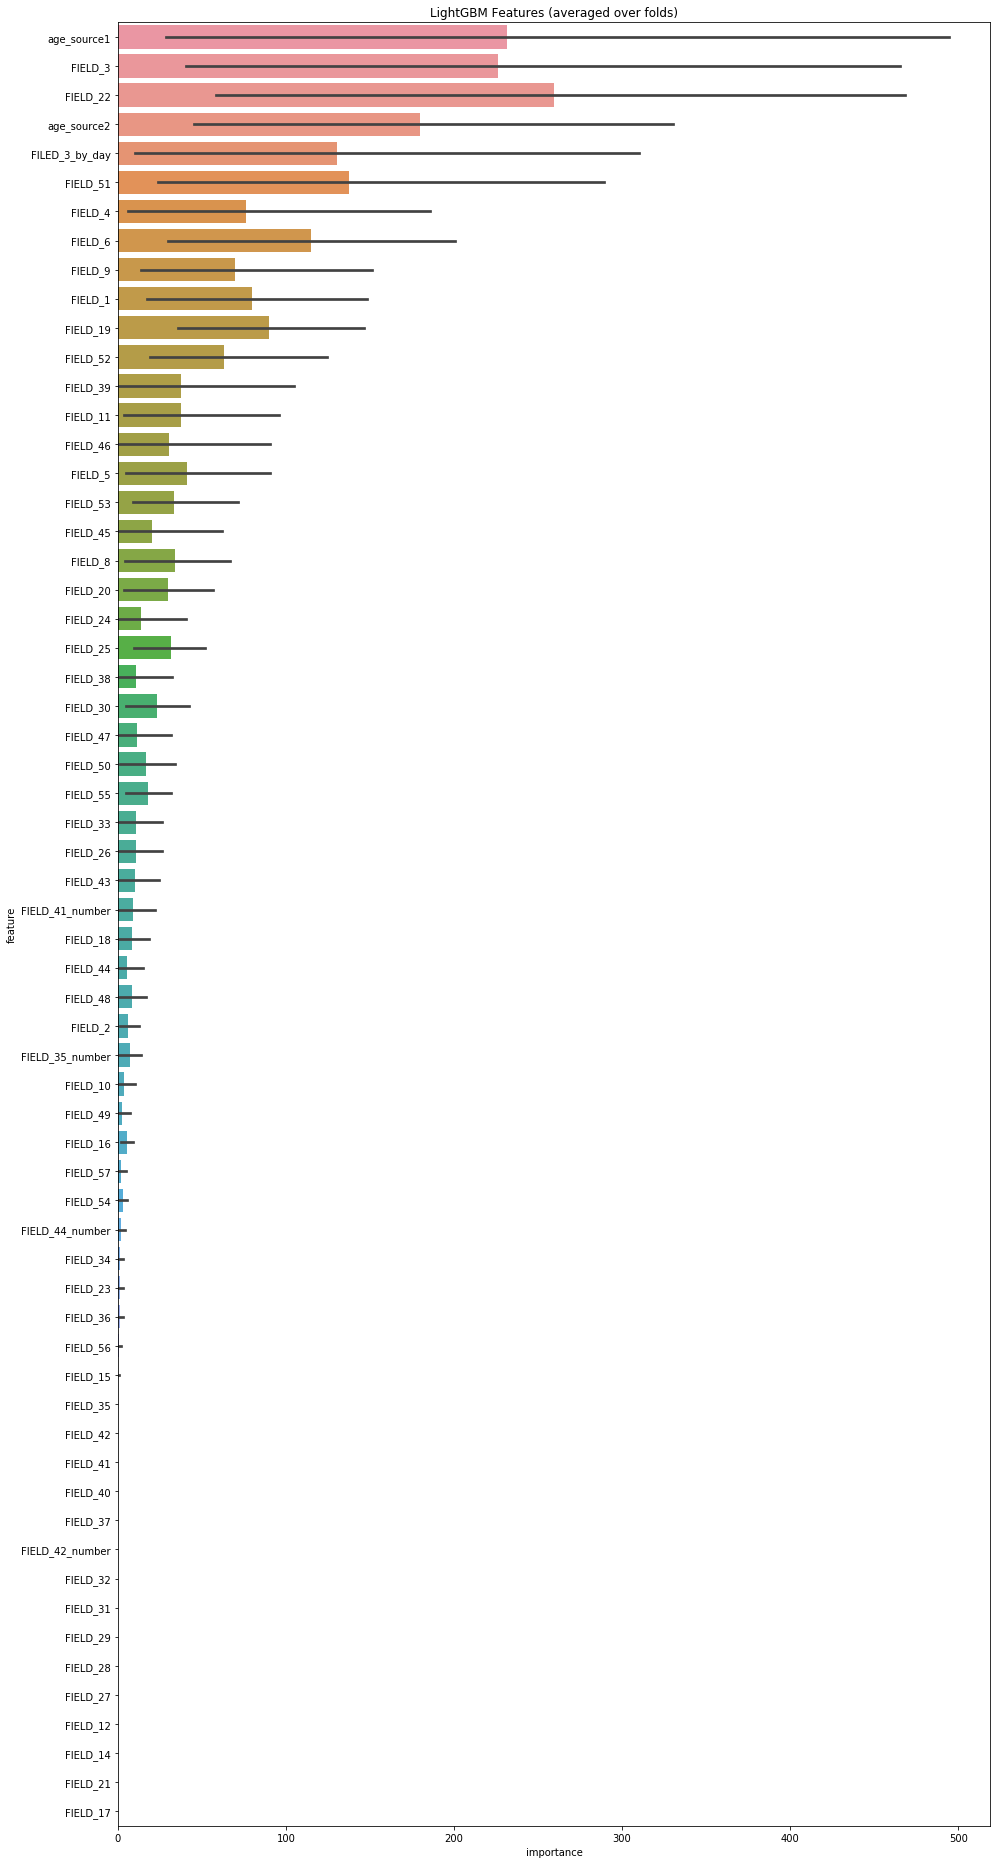

In [31]:

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [51]:
from bayes_opt import BayesianOptimization

fold__ = 5
def LGB_CV(
          max_depth,
          num_leaves,
          min_data_in_leaf,
          feature_fraction,
          bagging_fraction,
          lambda_l1,
          learning_rate
         ):
    kfold = 5
    folds = StratifiedKFold(n_splits=kfold, shuffle=False, random_state=44000)
    oof = np.zeros(len(train_X))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X.values, train_y.values)):
        print("fold n°{}".format(fold_))
        param = {
            'num_leaves': int(num_leaves),
            'min_data_in_leaf': int(min_data_in_leaf), 
            'objective':'binary',
            'max_depth': int(max_depth),
            'learning_rate': learning_rate,
            "feature_fraction": feature_fraction,
            "bagging_freq": 1,
            "bagging_fraction": bagging_fraction ,
            "bagging_seed": 11,
            "metric": 'auc',
            "lambda_l1": lambda_l1,
            'n_estimators': 1500,
            'boosting' : 'gbdt',
            "verbosity": -1,
            'seed':int(2**fold__),
            'bagging_seed':int(2**fold__),
            'drop_seed':int(2**fold__)
        }
        trn_data = lgb.Dataset(train_X.iloc[trn_idx][train_cols], label=train_y.iloc[trn_idx], categorical_feature=category_cols)
        val_data = lgb.Dataset(train_X.iloc[val_idx][train_cols], label=train_y.iloc[val_idx], categorical_feature=category_cols)
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=500, categorical_feature=category_cols)
        oof[val_idx] = clf.predict(train_X.iloc[val_idx][train_cols], num_iteration=clf.best_iteration)
        score_arr[fold_] = roc_auc_score(train_y.iloc[val_idx], oof[val_idx])
        
#         gc.collect()
        
    return roc_auc_score(train_y, oof)
LGB_BO = BayesianOptimization(LGB_CV, {
    'max_depth': (4, 10),
    'num_leaves': (5, 130),
    'min_data_in_leaf': (10, 150),
    'feature_fraction': (0.7, 1.0),
    'bagging_fraction': (0.7, 1.0),
    'lambda_l1': (0, 6),
    'learning_rate':(0.01, 0.05)
})

LGB_BO.maximize(init_points=2, n_iter=30, acq='ei', xi=0.0)

|   iter    |  target   | baggin... | featur... | lambda_l1 | learni... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.804747	valid_1's auc: 0.60665
[200]	training's auc: 0.862105	valid_1's auc: 0.594532
[300]	training's auc: 0.890547	valid_1's auc: 0.583915
[400]	training's auc: 0.909324	valid_1's auc: 0.569984
[500]	training's auc: 0.91731	valid_1's auc: 0.567324
Early stopping, best iteration is:
[4]	training's auc: 0.6892	valid_1's auc: 0.629585
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.819834	valid_1's auc: 0.576797
[200]	training's auc: 0.866684	valid_1's auc: 0.572463
[300]	training's auc: 0.890453	valid_1's auc: 0.564865
[400]	training's auc: 0.906386	valid_1's auc: 0.560195
[500]	training's auc: 0.915713	valid_1's auc: 0.556148
Early stopping, best iteration is:
[9]	training's auc: 0.699724	valid_1's auc: 0.589712
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.807097	valid_1's auc: 0.608625
[200]	training's auc: 0.851855	valid_1's auc: 0.609787
[300]	training's auc: 0.878307	valid_1's auc: 0.611867
[400]	training's auc: 0.894573	valid_1's auc: 0.610677
[500]	training's auc: 0.906877	valid_1's auc: 0.609856
[600]	training's auc: 0.916823	valid_1's auc: 0.610846
[700]	training's auc: 0.922464	valid_1's auc: 0.614061
[800]	training's auc: 0.927897	valid_1's auc: 0.610808
Early stopping, best iteration is:
[338]	training's auc: 0.885372	valid_1's auc: 0.61554
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.816099	valid_1's auc: 0.658863
[200]	training's auc: 0.868115	valid_1's auc: 0.640534
[300]	training's auc: 0.893716	valid_1's auc: 0.634407
[400]	training's auc: 0.906637	valid_1's auc: 0.632995
[500]	training's auc: 0.917752	valid_1's auc: 0.624152
[600]	training's auc: 0.926061	valid_1's auc: 0.621756
Early stopping, best iteration is:
[104]	training's auc: 0.820585	valid_1's auc: 0.660051
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.822034	valid_1's auc: 0.609911
[200]	training's auc: 0.867416	valid_1's auc: 0.603864
[300]	training's auc: 0.892467	valid_1's auc: 0.600243
[400]	training's auc: 0.907577	valid_1's auc: 0.596363
[500]	training's auc: 0.917323	valid_1's auc: 0.587712
Early stopping, best iteration is:
[98]	training's auc: 0.820249	valid_1's auc: 0.611001
|  1        |  0.6109   |  0.8355   |  0.8396   |  4.882    |  0.03584  |  5.837    |  67.76    |  121.2    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.810888	valid_1's auc: 0.609464
[200]	training's auc: 0.852679	valid_1's auc: 0.617861
[300]	training's auc: 0.883963	valid_1's auc: 0.610872
[400]	training's auc: 0.90501	valid_1's auc: 0.604937
[500]	training's auc: 0.915931	valid_1's auc: 0.604249
Early stopping, best iteration is:
[8]	training's auc: 0.731644	valid_1's auc: 0.629326
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.816469	valid_1's auc: 0.587361
[200]	training's auc: 0.862982	valid_1's auc: 0.586486
[300]	training's auc: 0.885879	valid_1's auc: 0.585754
[400]	training's auc: 0.901968	valid_1's auc: 0.582308
[500]	training's auc: 0.914089	valid_1's auc: 0.578272
Early stopping, best iteration is:
[9]	training's auc: 0.745468	valid_1's auc: 0.599755
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.806621	valid_1's auc: 0.60826
[200]	training's auc: 0.853994	valid_1's auc: 0.612467
[300]	training's auc: 0.879311	valid_1's auc: 0.613736
[400]	training's auc: 0.897335	valid_1's auc: 0.612996
[500]	training's auc: 0.909844	valid_1's auc: 0.611714
[600]	training's auc: 0.919151	valid_1's auc: 0.611686
Early stopping, best iteration is:
[132]	training's auc: 0.823229	valid_1's auc: 0.614847
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.817356	valid_1's auc: 0.655521
[200]	training's auc: 0.861984	valid_1's auc: 0.654929
[300]	training's auc: 0.889428	valid_1's auc: 0.653343
[400]	training's auc: 0.904545	valid_1's auc: 0.648539
[500]	training's auc: 0.917243	valid_1's auc: 0.640042
[600]	training's auc: 0.923651	valid_1's auc: 0.636968
Early stopping, best iteration is:
[119]	training's auc: 0.82841	valid_1's auc: 0.659971
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.828222	valid_1's auc: 0.603735
[200]	training's auc: 0.871884	valid_1's auc: 0.600688
[300]	training's auc: 0.893287	valid_1's auc: 0.599973
[400]	training's auc: 0.90812	valid_1's auc: 0.600306
[500]	training's auc: 0.920403	valid_1's auc: 0.590499
Early stopping, best iteration is:
[2]	training's auc: 0.690793	valid_1's auc: 0.613676
|  2        |  0.6113   |  0.8031   |  0.7058   |  1.352    |  0.01249  |  5.204    |  53.19    |  74.41    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.747137	valid_1's auc: 0.620017
[200]	training's auc: 0.806772	valid_1's auc: 0.618765
[300]	training's auc: 0.843393	valid_1's auc: 0.617665
[400]	training's auc: 0.865566	valid_1's auc: 0.611993
[500]	training's auc: 0.880643	valid_1's auc: 0.604573
Early stopping, best iteration is:
[22]	training's auc: 0.689821	valid_1's auc: 0.636933
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.760689	valid_1's auc: 0.589316
[200]	training's auc: 0.814756	valid_1's auc: 0.581528
[300]	training's auc: 0.844574	valid_1's auc: 0.583641
[400]	training's auc: 0.868025	valid_1's auc: 0.577195
[500]	training's auc: 0.884274	valid_1's auc: 0.573623
[600]	training's auc: 0.89525	valid_1's auc: 0.570826
Early stopping, best iteration is:
[149]	training's auc: 0.791689	valid_1's auc: 0.591206
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.752892	valid_1's auc: 0.610952
[200]	training's auc: 0.805038	valid_1's auc: 0.606215
[300]	training's auc: 0.836248	valid_1's auc: 0.596458
[400]	training's auc: 0.856702	valid_1's auc: 0.596469
[500]	training's auc: 0.875026	valid_1's auc: 0.597164
Early stopping, best iteration is:
[45]	training's auc: 0.715294	valid_1's auc: 0.620305
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.74725	valid_1's auc: 0.665215
[200]	training's auc: 0.805856	valid_1's auc: 0.670666
[300]	training's auc: 0.842501	valid_1's auc: 0.660886
[400]	training's auc: 0.865109	valid_1's auc: 0.643596
[500]	training's auc: 0.882563	valid_1's auc: 0.635684
[600]	training's auc: 0.893112	valid_1's auc: 0.631765
Early stopping, best iteration is:
[198]	training's auc: 0.805092	valid_1's auc: 0.672304
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.765121	valid_1's auc: 0.601212
[200]	training's auc: 0.816226	valid_1's auc: 0.602102
[300]	training's auc: 0.846965	valid_1's auc: 0.596742
[400]	training's auc: 0.868594	valid_1's auc: 0.592242
[500]	training's auc: 0.882942	valid_1's auc: 0.587255
Early stopping, best iteration is:
[5]	training's auc: 0.651935	valid_1's auc: 0.610406
|  3        |  0.617    |  0.8089   |  0.8538   |  0.5292   |  0.03406  |  8.528    |  149.9    |  6.533    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.720395	valid_1's auc: 0.601881
[200]	training's auc: 0.755746	valid_1's auc: 0.600865
[300]	training's auc: 0.783508	valid_1's auc: 0.602515
[400]	training's auc: 0.803178	valid_1's auc: 0.600911
[500]	training's auc: 0.818226	valid_1's auc: 0.595893
Early stopping, best iteration is:
[4]	training's auc: 0.639818	valid_1's auc: 0.636049
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.727051	valid_1's auc: 0.580531
[200]	training's auc: 0.764192	valid_1's auc: 0.571335
[300]	training's auc: 0.792588	valid_1's auc: 0.571004
[400]	training's auc: 0.810978	valid_1's auc: 0.568549
[500]	training's auc: 0.826899	valid_1's auc: 0.5689
[600]	training's auc: 0.838608	valid_1's auc: 0.570814
Early stopping, best iteration is:
[113]	training's auc: 0.731809	valid_1's auc: 0.582134
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.721398	valid_1's auc: 0.588753
[200]	training's auc: 0.755087	valid_1's auc: 0.588656
[300]	training's auc: 0.780487	valid_1's auc: 0.590651
[400]	training's auc: 0.79889	valid_1's auc: 0.590549
[500]	training's auc: 0.813175	valid_1's auc: 0.592391
[600]	training's auc: 0.827817	valid_1's auc: 0.597605
[700]	training's auc: 0.836351	valid_1's auc: 0.598639
[800]	training's auc: 0.844619	valid_1's auc: 0.602352
[900]	training's auc: 0.854294	valid_1's auc: 0.600452
[1000]	training's auc: 0.862119	valid_1's auc: 0.601144
[1100]	training's auc: 0.86915	valid_1's auc: 0.601535
[1200]	training's auc: 0.873848	valid_1's auc: 0.603376
[1300]	training's auc: 0.879613	valid_1's auc: 0.602228
[1400]	training's auc: 0.883654	valid_1's auc: 0.601027
[1500]	training's auc: 0.888109	valid_1's auc: 0.605063
Did not meet early stopping. Best iteration is:
[1500]	training's auc: 0.888109	valid_1's auc: 0.605063
fold 

c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.713261	valid_1's auc: 0.645997
[200]	training's auc: 0.75816	valid_1's auc: 0.641625
[300]	training's auc: 0.784992	valid_1's auc: 0.638944
[400]	training's auc: 0.808046	valid_1's auc: 0.63571
[500]	training's auc: 0.824066	valid_1's auc: 0.634221
Early stopping, best iteration is:
[81]	training's auc: 0.702969	valid_1's auc: 0.650994
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.728441	valid_1's auc: 0.608173
[200]	training's auc: 0.764921	valid_1's auc: 0.608376
[300]	training's auc: 0.787995	valid_1's auc: 0.60855
[400]	training's auc: 0.807667	valid_1's auc: 0.604994
[500]	training's auc: 0.824685	valid_1's auc: 0.599043
Early stopping, best iteration is:
[77]	training's auc: 0.717174	valid_1's auc: 0.613199
|  4        |  0.6017   |  0.8518   |  0.9694   |  3.771    |  0.03749  |  5.504    |  148.3    |  5.199    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.884915	valid_1's auc: 0.614904
[200]	training's auc: 0.921213	valid_1's auc: 0.613505
[300]	training's auc: 0.933553	valid_1's auc: 0.608409
[400]	training's auc: 0.94358	valid_1's auc: 0.597621
[500]	training's auc: 0.948681	valid_1's auc: 0.590022
Early stopping, best iteration is:
[66]	training's auc: 0.86204	valid_1's auc: 0.625841
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.886843	valid_1's auc: 0.599389
[200]	training's auc: 0.921588	valid_1's auc: 0.589713
[300]	training's auc: 0.935599	valid_1's auc: 0.589015
[400]	training's auc: 0.942905	valid_1's auc: 0.590932
[500]	training's auc: 0.947547	valid_1's auc: 0.58573
Early stopping, best iteration is:
[8]	training's auc: 0.798002	valid_1's auc: 0.611632
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.883894	valid_1's auc: 0.613993
[200]	training's auc: 0.916536	valid_1's auc: 0.610052
[300]	training's auc: 0.930914	valid_1's auc: 0.610128
[400]	training's auc: 0.939898	valid_1's auc: 0.610134
[500]	training's auc: 0.946297	valid_1's auc: 0.611927
Early stopping, best iteration is:
[18]	training's auc: 0.835898	valid_1's auc: 0.62382
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.891975	valid_1's auc: 0.642789
[200]	training's auc: 0.92475	valid_1's auc: 0.652078
[300]	training's auc: 0.936651	valid_1's auc: 0.646096
[400]	training's auc: 0.943412	valid_1's auc: 0.640668
[500]	training's auc: 0.948561	valid_1's auc: 0.633436
[600]	training's auc: 0.953075	valid_1's auc: 0.626224
[700]	training's auc: 0.956823	valid_1's auc: 0.622811
Early stopping, best iteration is:
[202]	training's auc: 0.925088	valid_1's auc: 0.652969
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.895146	valid_1's auc: 0.601291
[200]	training's auc: 0.926085	valid_1's auc: 0.590722
[300]	training's auc: 0.938636	valid_1's auc: 0.59229
[400]	training's auc: 0.946092	valid_1's auc: 0.58552
[500]	training's auc: 0.950587	valid_1's auc: 0.581656
[600]	training's auc: 0.955265	valid_1's auc: 0.57923
Early stopping, best iteration is:
[108]	training's auc: 0.899209	valid_1's auc: 0.602361
|  5        |  0.6167   |  0.751    |  0.7466   |  0.3083   |  0.01002  |  9.673    |  149.7    |  118.5    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.774404	valid_1's auc: 0.612892
[200]	training's auc: 0.829483	valid_1's auc: 0.620353
[300]	training's auc: 0.863763	valid_1's auc: 0.611382
[400]	training's auc: 0.887972	valid_1's auc: 0.603175
[500]	training's auc: 0.900133	valid_1's auc: 0.59123
Early stopping, best iteration is:
[9]	training's auc: 0.6908	valid_1's auc: 0.627981
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.782398	valid_1's auc: 0.600386
[200]	training's auc: 0.840549	valid_1's auc: 0.596482
[300]	training's auc: 0.871346	valid_1's auc: 0.592401
[400]	training's auc: 0.891459	valid_1's auc: 0.586448
[500]	training's auc: 0.90493	valid_1's auc: 0.584436
Early stopping, best iteration is:
[37]	training's auc: 0.726996	valid_1's auc: 0.605224
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.773123	valid_1's auc: 0.608712
[200]	training's auc: 0.828801	valid_1's auc: 0.601649
[300]	training's auc: 0.862009	valid_1's auc: 0.600512
[400]	training's auc: 0.882111	valid_1's auc: 0.595726
[500]	training's auc: 0.896893	valid_1's auc: 0.599901
Early stopping, best iteration is:
[68]	training's auc: 0.748313	valid_1's auc: 0.612085
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.772243	valid_1's auc: 0.665113
[200]	training's auc: 0.837426	valid_1's auc: 0.666742
[300]	training's auc: 0.87123	valid_1's auc: 0.656325
[400]	training's auc: 0.89051	valid_1's auc: 0.651876
[500]	training's auc: 0.905965	valid_1's auc: 0.647828
[600]	training's auc: 0.915196	valid_1's auc: 0.640624
Early stopping, best iteration is:
[132]	training's auc: 0.797921	valid_1's auc: 0.672566
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.784182	valid_1's auc: 0.61987
[200]	training's auc: 0.836671	valid_1's auc: 0.619014
[300]	training's auc: 0.870246	valid_1's auc: 0.614569
[400]	training's auc: 0.89015	valid_1's auc: 0.610721
[500]	training's auc: 0.902569	valid_1's auc: 0.607218
Early stopping, best iteration is:
[31]	training's auc: 0.729381	valid_1's auc: 0.626456
|  6        |  0.6205   |  0.7373   |  0.8684   |  0.2979   |  0.01924  |  7.725    |  150.0    |  10.47    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.969118	valid_1's auc: 0.579786
[200]	training's auc: 0.979731	valid_1's auc: 0.580841
[300]	training's auc: 0.982648	valid_1's auc: 0.571658
[400]	training's auc: 0.984767	valid_1's auc: 0.570144
[500]	training's auc: 0.985801	valid_1's auc: 0.567999
Early stopping, best iteration is:
[4]	training's auc: 0.855207	valid_1's auc: 0.603698
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.969136	valid_1's auc: 0.573194
[200]	training's auc: 0.977804	valid_1's auc: 0.564236
[300]	training's auc: 0.981973	valid_1's auc: 0.559807
[400]	training's auc: 0.983781	valid_1's auc: 0.556148
[500]	training's auc: 0.984966	valid_1's auc: 0.547502
Early stopping, best iteration is:
[3]	training's auc: 0.825806	valid_1's auc: 0.588597
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.968472	valid_1's auc: 0.623595
[200]	training's auc: 0.979641	valid_1's auc: 0.621817
[300]	training's auc: 0.983377	valid_1's auc: 0.626033
[400]	training's auc: 0.98522	valid_1's auc: 0.622415
[500]	training's auc: 0.986566	valid_1's auc: 0.622813
[600]	training's auc: 0.987229	valid_1's auc: 0.620583
[700]	training's auc: 0.987896	valid_1's auc: 0.619386
Early stopping, best iteration is:
[296]	training's auc: 0.9833	valid_1's auc: 0.626573
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.969024	valid_1's auc: 0.629289
[200]	training's auc: 0.978688	valid_1's auc: 0.628475
[300]	training's auc: 0.983389	valid_1's auc: 0.620991
[400]	training's auc: 0.985136	valid_1's auc: 0.618946
[500]	training's auc: 0.986476	valid_1's auc: 0.614531
Early stopping, best iteration is:
[31]	training's auc: 0.948679	valid_1's auc: 0.653213
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.969714	valid_1's auc: 0.575104
[200]	training's auc: 0.979184	valid_1's auc: 0.565809
[300]	training's auc: 0.982694	valid_1's auc: 0.56285
[400]	training's auc: 0.984029	valid_1's auc: 0.566992
[500]	training's auc: 0.985011	valid_1's auc: 0.562433
Early stopping, best iteration is:
[36]	training's auc: 0.954616	valid_1's auc: 0.592237
|  7        |  0.5955   |  0.7      |  0.843    |  0.9755   |  0.04674  |  9.731    |  12.24    |  126.5    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.937221	valid_1's auc: 0.610805
[200]	training's auc: 0.956615	valid_1's auc: 0.595856
[300]	training's auc: 0.96693	valid_1's auc: 0.587621
[400]	training's auc: 0.975509	valid_1's auc: 0.584768
[500]	training's auc: 0.980197	valid_1's auc: 0.58258
Early stopping, best iteration is:
[2]	training's auc: 0.757043	valid_1's auc: 0.6303
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.937549	valid_1's auc: 0.588745
[200]	training's auc: 0.955087	valid_1's auc: 0.588817
[300]	training's auc: 0.966772	valid_1's auc: 0.58706
[400]	training's auc: 0.974023	valid_1's auc: 0.583513
[500]	training's auc: 0.978893	valid_1's auc: 0.58034
Early stopping, best iteration is:
[1]	training's auc: 0.72037	valid_1's auc: 0.606931
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.93539	valid_1's auc: 0.615096
[200]	training's auc: 0.954254	valid_1's auc: 0.615039
[300]	training's auc: 0.966885	valid_1's auc: 0.626257
[400]	training's auc: 0.97523	valid_1's auc: 0.631026
[500]	training's auc: 0.980237	valid_1's auc: 0.631934
[600]	training's auc: 0.983393	valid_1's auc: 0.63005
[700]	training's auc: 0.985418	valid_1's auc: 0.626362
[800]	training's auc: 0.986884	valid_1's auc: 0.623056
Early stopping, best iteration is:
[347]	training's auc: 0.97176	valid_1's auc: 0.632546
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.940027	valid_1's auc: 0.628726
[200]	training's auc: 0.955808	valid_1's auc: 0.626214
[300]	training's auc: 0.96679	valid_1's auc: 0.615062
[400]	training's auc: 0.974155	valid_1's auc: 0.614472
[500]	training's auc: 0.979272	valid_1's auc: 0.613143
Early stopping, best iteration is:
[25]	training's auc: 0.887157	valid_1's auc: 0.639791
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.941958	valid_1's auc: 0.592253
[200]	training's auc: 0.957431	valid_1's auc: 0.588668
[300]	training's auc: 0.967855	valid_1's auc: 0.580847
[400]	training's auc: 0.974264	valid_1's auc: 0.573319
[500]	training's auc: 0.977873	valid_1's auc: 0.569285
Early stopping, best iteration is:
[55]	training's auc: 0.925594	valid_1's auc: 0.600715
|  8        |  0.5986   |  0.8811   |  0.8039   |  0.1954   |  0.03075  |  9.642    |  126.1    |  74.68    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.769645	valid_1's auc: 0.600382
[200]	training's auc: 0.825051	valid_1's auc: 0.620766
[300]	training's auc: 0.854066	valid_1's auc: 0.611382
[400]	training's auc: 0.877044	valid_1's auc: 0.600605
[500]	training's auc: 0.891635	valid_1's auc: 0.597343
[600]	training's auc: 0.903905	valid_1's auc: 0.595106
[700]	training's auc: 0.915264	valid_1's auc: 0.59006
Early stopping, best iteration is:
[207]	training's auc: 0.828467	valid_1's auc: 0.622761
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.776799	valid_1's auc: 0.590511
[200]	training's auc: 0.830579	valid_1's auc: 0.592917
[300]	training's auc: 0.853377	valid_1's auc: 0.591654
[400]	training's auc: 0.876372	valid_1's auc: 0.588741
[500]	training's auc: 0.890786	valid_1's auc: 0.587608
[600]	training's auc: 0.902572	valid_1's auc: 0.581756
[700]	training's auc: 0.915537	valid_1's auc: 0.582634
Early stopping, best iteration is:
[263]	training's auc: 0.847823	valid_1's auc: 0.596898
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.766093	valid_1's auc: 0.605168
[200]	training's auc: 0.822574	valid_1's auc: 0.595098
[300]	training's auc: 0.850416	valid_1's auc: 0.586102
[400]	training's auc: 0.877455	valid_1's auc: 0.578841
[500]	training's auc: 0.891686	valid_1's auc: 0.584008
Early stopping, best iteration is:
[85]	training's auc: 0.760639	valid_1's auc: 0.611671
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.754368	valid_1's auc: 0.6486
[200]	training's auc: 0.820342	valid_1's auc: 0.650001
[300]	training's auc: 0.852483	valid_1's auc: 0.646801
[400]	training's auc: 0.873034	valid_1's auc: 0.63566
[500]	training's auc: 0.887219	valid_1's auc: 0.627753
[600]	training's auc: 0.899348	valid_1's auc: 0.62037
[700]	training's auc: 0.911217	valid_1's auc: 0.609927
Early stopping, best iteration is:
[226]	training's auc: 0.832471	valid_1's auc: 0.657224
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.772738	valid_1's auc: 0.603174
[200]	training's auc: 0.826249	valid_1's auc: 0.607321
[300]	training's auc: 0.859617	valid_1's auc: 0.604373
[400]	training's auc: 0.878502	valid_1's auc: 0.60101
[500]	training's auc: 0.892884	valid_1's auc: 0.603013
[600]	training's auc: 0.903205	valid_1's auc: 0.602037
Early stopping, best iteration is:
[149]	training's auc: 0.804132	valid_1's auc: 0.616787
|  9        |  0.6154   |  0.9171   |  0.8571   |  0.2203   |  0.04424  |  6.459    |  17.33    |  5.01     |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.889846	valid_1's auc: 0.600885
[200]	training's auc: 0.925853	valid_1's auc: 0.59221
[300]	training's auc: 0.941005	valid_1's auc: 0.581839
[400]	training's auc: 0.952691	valid_1's auc: 0.581181
[500]	training's auc: 0.959854	valid_1's auc: 0.576245
Early stopping, best iteration is:
[34]	training's auc: 0.825537	valid_1's auc: 0.625806
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.888205	valid_1's auc: 0.587016
[200]	training's auc: 0.925211	valid_1's auc: 0.582226
[300]	training's auc: 0.94086	valid_1's auc: 0.577575
[400]	training's auc: 0.950842	valid_1's auc: 0.578133
[500]	training's auc: 0.958461	valid_1's auc: 0.575153
Early stopping, best iteration is:
[80]	training's auc: 0.876965	valid_1's auc: 0.592891
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.887444	valid_1's auc: 0.609041
[200]	training's auc: 0.919951	valid_1's auc: 0.609251
[300]	training's auc: 0.937539	valid_1's auc: 0.609096
[400]	training's auc: 0.950736	valid_1's auc: 0.613649
[500]	training's auc: 0.959383	valid_1's auc: 0.616709
[600]	training's auc: 0.965318	valid_1's auc: 0.620097
[700]	training's auc: 0.970854	valid_1's auc: 0.624004
[800]	training's auc: 0.975045	valid_1's auc: 0.627102
[900]	training's auc: 0.978258	valid_1's auc: 0.627907
[1000]	training's auc: 0.980288	valid_1's auc: 0.632556
[1100]	training's auc: 0.982067	valid_1's auc: 0.630661
[1200]	training's auc: 0.983266	valid_1's auc: 0.629882
[1300]	training's auc: 0.984479	valid_1's auc: 0.630829
[1400]	training's auc: 0.985457	valid_1's auc: 0.630417
Early stopping, best iteration is:
[989]	training's auc: 0.980032	valid_1's auc: 0.633641
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.88702	valid_1's auc: 0.640641
[200]	training's auc: 0.924858	valid_1's auc: 0.618956
[300]	training's auc: 0.943091	valid_1's auc: 0.615982
[400]	training's auc: 0.952881	valid_1's auc: 0.604073
[500]	training's auc: 0.960925	valid_1's auc: 0.605512
Early stopping, best iteration is:
[29]	training's auc: 0.822553	valid_1's auc: 0.644679
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.893157	valid_1's auc: 0.591913
[200]	training's auc: 0.926664	valid_1's auc: 0.585762
[300]	training's auc: 0.943951	valid_1's auc: 0.57028
[400]	training's auc: 0.953933	valid_1's auc: 0.560363
[500]	training's auc: 0.960088	valid_1's auc: 0.547201
Early stopping, best iteration is:
[98]	training's auc: 0.89324	valid_1's auc: 0.593471
|  10       |  0.6025   |  0.8627   |  0.7096   |  0.1063   |  0.04363  |  5.292    |  74.79    |  129.9    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.892304	valid_1's auc: 0.590055
[200]	training's auc: 0.931091	valid_1's auc: 0.577447
[300]	training's auc: 0.941365	valid_1's auc: 0.567381
[400]	training's auc: 0.949628	valid_1's auc: 0.563267
[500]	training's auc: 0.952509	valid_1's auc: 0.560643
Early stopping, best iteration is:
[3]	training's auc: 0.712691	valid_1's auc: 0.632335
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.892654	valid_1's auc: 0.558418
[200]	training's auc: 0.925801	valid_1's auc: 0.546455
[300]	training's auc: 0.937931	valid_1's auc: 0.54535
[400]	training's auc: 0.944661	valid_1's auc: 0.543672
[500]	training's auc: 0.948419	valid_1's auc: 0.542027
Early stopping, best iteration is:
[8]	training's auc: 0.73881	valid_1's auc: 0.575357
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.886444	valid_1's auc: 0.603909
[200]	training's auc: 0.921023	valid_1's auc: 0.61097
[300]	training's auc: 0.936106	valid_1's auc: 0.610039
[400]	training's auc: 0.943245	valid_1's auc: 0.605186
[500]	training's auc: 0.948151	valid_1's auc: 0.608839
Early stopping, best iteration is:
[1]	training's auc: 0.68371	valid_1's auc: 0.614343
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.896238	valid_1's auc: 0.643486
[200]	training's auc: 0.928563	valid_1's auc: 0.631696
[300]	training's auc: 0.940508	valid_1's auc: 0.629792
[400]	training's auc: 0.947544	valid_1's auc: 0.624318
[500]	training's auc: 0.951588	valid_1's auc: 0.620481
Early stopping, best iteration is:
[11]	training's auc: 0.739494	valid_1's auc: 0.660788
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.896671	valid_1's auc: 0.599735
[200]	training's auc: 0.930626	valid_1's auc: 0.585038
[300]	training's auc: 0.943487	valid_1's auc: 0.579261
[400]	training's auc: 0.949665	valid_1's auc: 0.574348
[500]	training's auc: 0.952655	valid_1's auc: 0.570318
Early stopping, best iteration is:
[46]	training's auc: 0.844126	valid_1's auc: 0.606054
|  11       |  0.6098   |  0.8567   |  0.991    |  5.07     |  0.04477  |  8.336    |  10.06    |  49.45    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.870416	valid_1's auc: 0.620394
[200]	training's auc: 0.917323	valid_1's auc: 0.612107
[300]	training's auc: 0.934253	valid_1's auc: 0.597224
[400]	training's auc: 0.942723	valid_1's auc: 0.591433
[500]	training's auc: 0.949719	valid_1's auc: 0.586768
Early stopping, best iteration is:
[25]	training's auc: 0.78982	valid_1's auc: 0.627791
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.869913	valid_1's auc: 0.589484
[200]	training's auc: 0.917209	valid_1's auc: 0.592344
[300]	training's auc: 0.931994	valid_1's auc: 0.595884
[400]	training's auc: 0.941536	valid_1's auc: 0.595094
[500]	training's auc: 0.946886	valid_1's auc: 0.592361
[600]	training's auc: 0.953109	valid_1's auc: 0.588264
[700]	training's auc: 0.957399	valid_1's auc: 0.585242
Early stopping, best iteration is:
[287]	training's auc: 0.93062	valid_1's auc: 0.597502
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.864853	valid_1's auc: 0.609362
[200]	training's auc: 0.912245	valid_1's auc: 0.615259
[300]	training's auc: 0.92918	valid_1's auc: 0.613213
[400]	training's auc: 0.939559	valid_1's auc: 0.613082
[500]	training's auc: 0.94642	valid_1's auc: 0.615321
[600]	training's auc: 0.952411	valid_1's auc: 0.616782
Early stopping, best iteration is:
[132]	training's auc: 0.886687	valid_1's auc: 0.618018
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.885441	valid_1's auc: 0.658866
[200]	training's auc: 0.920326	valid_1's auc: 0.660929
[300]	training's auc: 0.934605	valid_1's auc: 0.653444
[400]	training's auc: 0.942985	valid_1's auc: 0.649764
[500]	training's auc: 0.949	valid_1's auc: 0.639732
[600]	training's auc: 0.953598	valid_1's auc: 0.63595
Early stopping, best iteration is:
[128]	training's auc: 0.900234	valid_1's auc: 0.662658
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.882526	valid_1's auc: 0.594441
[200]	training's auc: 0.926514	valid_1's auc: 0.592488
[300]	training's auc: 0.937267	valid_1's auc: 0.588467
[400]	training's auc: 0.945587	valid_1's auc: 0.585693
[500]	training's auc: 0.951332	valid_1's auc: 0.58057
Early stopping, best iteration is:
[12]	training's auc: 0.778869	valid_1's auc: 0.614006
|  12       |  0.6127   |  0.9526   |  0.8874   |  0.8153   |  0.0145   |  9.682    |  149.7    |  34.92    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.823669	valid_1's auc: 0.630691
[200]	training's auc: 0.868684	valid_1's auc: 0.620204
[300]	training's auc: 0.895832	valid_1's auc: 0.605965
[400]	training's auc: 0.910637	valid_1's auc: 0.601377
[500]	training's auc: 0.920239	valid_1's auc: 0.593097
Early stopping, best iteration is:
[4]	training's auc: 0.677526	valid_1's auc: 0.640566
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.826329	valid_1's auc: 0.597302
[200]	training's auc: 0.873176	valid_1's auc: 0.588412
[300]	training's auc: 0.89802	valid_1's auc: 0.591384
[400]	training's auc: 0.911066	valid_1's auc: 0.590814
[500]	training's auc: 0.92168	valid_1's auc: 0.585294
Early stopping, best iteration is:
[86]	training's auc: 0.818588	valid_1's auc: 0.598397
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.807045	valid_1's auc: 0.599941
[200]	training's auc: 0.857466	valid_1's auc: 0.587766
[300]	training's auc: 0.88508	valid_1's auc: 0.586285
[400]	training's auc: 0.903489	valid_1's auc: 0.585054
[500]	training's auc: 0.915011	valid_1's auc: 0.585692
Early stopping, best iteration is:
[4]	training's auc: 0.689881	valid_1's auc: 0.61399
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.818435	valid_1's auc: 0.662421
[200]	training's auc: 0.865674	valid_1's auc: 0.640674
[300]	training's auc: 0.893934	valid_1's auc: 0.627933
[400]	training's auc: 0.912569	valid_1's auc: 0.617175
[500]	training's auc: 0.921381	valid_1's auc: 0.612979
Early stopping, best iteration is:
[92]	training's auc: 0.813049	valid_1's auc: 0.66835
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.816372	valid_1's auc: 0.602435
[200]	training's auc: 0.87014	valid_1's auc: 0.597452
[300]	training's auc: 0.898831	valid_1's auc: 0.604026
[400]	training's auc: 0.91451	valid_1's auc: 0.593315
[500]	training's auc: 0.924761	valid_1's auc: 0.587433
Early stopping, best iteration is:
[30]	training's auc: 0.755687	valid_1's auc: 0.612985
|  13       |  0.6142   |  0.9502   |  0.7884   |  0.2184   |  0.03803  |  4.844    |  149.0    |  94.55    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.765884	valid_1's auc: 0.620246
[200]	training's auc: 0.816805	valid_1's auc: 0.623529
[300]	training's auc: 0.852202	valid_1's auc: 0.611563
[400]	training's auc: 0.877174	valid_1's auc: 0.605793
[500]	training's auc: 0.890899	valid_1's auc: 0.601605
Early stopping, best iteration is:
[3]	training's auc: 0.668949	valid_1's auc: 0.629674
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.776116	valid_1's auc: 0.590986
[200]	training's auc: 0.829837	valid_1's auc: 0.586485
[300]	training's auc: 0.857538	valid_1's auc: 0.583491
[400]	training's auc: 0.874466	valid_1's auc: 0.577883
[500]	training's auc: 0.889007	valid_1's auc: 0.579114
Early stopping, best iteration is:
[48]	training's auc: 0.745182	valid_1's auc: 0.603016
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.7683	valid_1's auc: 0.620438
[200]	training's auc: 0.813349	valid_1's auc: 0.607084
[300]	training's auc: 0.841686	valid_1's auc: 0.608139
[400]	training's auc: 0.86168	valid_1's auc: 0.606725
[500]	training's auc: 0.877989	valid_1's auc: 0.60685
Early stopping, best iteration is:
[89]	training's auc: 0.761117	valid_1's auc: 0.620902
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.768166	valid_1's auc: 0.655462
[200]	training's auc: 0.82829	valid_1's auc: 0.660035
[300]	training's auc: 0.855505	valid_1's auc: 0.653121
[400]	training's auc: 0.875438	valid_1's auc: 0.643531
[500]	training's auc: 0.891667	valid_1's auc: 0.636377
Early stopping, best iteration is:
[43]	training's auc: 0.727077	valid_1's auc: 0.662273
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.779382	valid_1's auc: 0.622809
[200]	training's auc: 0.820807	valid_1's auc: 0.624052
[300]	training's auc: 0.857044	valid_1's auc: 0.622373
[400]	training's auc: 0.878086	valid_1's auc: 0.617221
[500]	training's auc: 0.893099	valid_1's auc: 0.611244
Early stopping, best iteration is:
[55]	training's auc: 0.75324	valid_1's auc: 0.630353
|  14       |  0.6143   |  0.7058   |  0.8472   |  0.3714   |  0.01709  |  4.075    |  148.3    |  127.9    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.742337	valid_1's auc: 0.603859
[200]	training's auc: 0.781523	valid_1's auc: 0.611235
[300]	training's auc: 0.80603	valid_1's auc: 0.604559
[400]	training's auc: 0.826983	valid_1's auc: 0.597972
[500]	training's auc: 0.841314	valid_1's auc: 0.593342
[600]	training's auc: 0.853448	valid_1's auc: 0.59025
[700]	training's auc: 0.863514	valid_1's auc: 0.584461
Early stopping, best iteration is:
[201]	training's auc: 0.781731	valid_1's auc: 0.611606
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.747096	valid_1's auc: 0.568275
[200]	training's auc: 0.786449	valid_1's auc: 0.566727
[300]	training's auc: 0.812528	valid_1's auc: 0.566692
[400]	training's auc: 0.831183	valid_1's auc: 0.56338
[500]	training's auc: 0.845324	valid_1's auc: 0.560326
[600]	training's auc: 0.855896	valid_1's auc: 0.557759
Early stopping, best iteration is:
[114]	training's auc: 0.752702	valid_1's auc: 0.571599
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.742038	valid_1's auc: 0.595998
[200]	training's auc: 0.780107	valid_1's auc: 0.597013
[300]	training's auc: 0.802246	valid_1's auc: 0.599945
[400]	training's auc: 0.819374	valid_1's auc: 0.600708
[500]	training's auc: 0.832166	valid_1's auc: 0.603072
[600]	training's auc: 0.845079	valid_1's auc: 0.602273
[700]	training's auc: 0.855544	valid_1's auc: 0.597788
[800]	training's auc: 0.863423	valid_1's auc: 0.603368
[900]	training's auc: 0.871809	valid_1's auc: 0.601985
[1000]	training's auc: 0.878232	valid_1's auc: 0.603377
Early stopping, best iteration is:
[550]	training's auc: 0.839235	valid_1's auc: 0.605361
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.73523	valid_1's auc: 0.652285
[200]	training's auc: 0.781184	valid_1's auc: 0.648232
[300]	training's auc: 0.808501	valid_1's auc: 0.64218
[400]	training's auc: 0.830312	valid_1's auc: 0.638119
[500]	training's auc: 0.847881	valid_1's auc: 0.63373
[600]	training's auc: 0.859337	valid_1's auc: 0.631569
Early stopping, best iteration is:
[107]	training's auc: 0.738387	valid_1's auc: 0.65355
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.751338	valid_1's auc: 0.608106
[200]	training's auc: 0.792132	valid_1's auc: 0.609416
[300]	training's auc: 0.812709	valid_1's auc: 0.611308
[400]	training's auc: 0.831062	valid_1's auc: 0.608129
[500]	training's auc: 0.844837	valid_1's auc: 0.602986
[600]	training's auc: 0.854565	valid_1's auc: 0.600008
[700]	training's auc: 0.863994	valid_1's auc: 0.597469
Early stopping, best iteration is:
[289]	training's auc: 0.810562	valid_1's auc: 0.613295
|  15       |  0.607    |  0.7586   |  0.8863   |  5.723    |  0.02195  |  4.161    |  12.62    |  87.59    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.729001	valid_1's auc: 0.623473
[200]	training's auc: 0.774456	valid_1's auc: 0.609529
[300]	training's auc: 0.806356	valid_1's auc: 0.607664
[400]	training's auc: 0.827507	valid_1's auc: 0.603428
[500]	training's auc: 0.841357	valid_1's auc: 0.605229
Early stopping, best iteration is:
[18]	training's auc: 0.649108	valid_1's auc: 0.628773
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.735029	valid_1's auc: 0.587445
[200]	training's auc: 0.780537	valid_1's auc: 0.595814
[300]	training's auc: 0.810567	valid_1's auc: 0.593837
[400]	training's auc: 0.828339	valid_1's auc: 0.595821
[500]	training's auc: 0.843269	valid_1's auc: 0.591869
[600]	training's auc: 0.854089	valid_1's auc: 0.593048
Early stopping, best iteration is:
[187]	training's auc: 0.776701	valid_1's auc: 0.59844
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.731771	valid_1's auc: 0.610745
[200]	training's auc: 0.770717	valid_1's auc: 0.616854
[300]	training's auc: 0.794748	valid_1's auc: 0.607867
[400]	training's auc: 0.812502	valid_1's auc: 0.605953
[500]	training's auc: 0.829271	valid_1's auc: 0.603598
[600]	training's auc: 0.846058	valid_1's auc: 0.601708
Early stopping, best iteration is:
[184]	training's auc: 0.76466	valid_1's auc: 0.619653
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.724902	valid_1's auc: 0.638147
[200]	training's auc: 0.764054	valid_1's auc: 0.64479
[300]	training's auc: 0.797919	valid_1's auc: 0.640798
[400]	training's auc: 0.820209	valid_1's auc: 0.643152
[500]	training's auc: 0.839573	valid_1's auc: 0.642167
[600]	training's auc: 0.852805	valid_1's auc: 0.641134
[700]	training's auc: 0.863211	valid_1's auc: 0.63734
Early stopping, best iteration is:
[277]	training's auc: 0.787971	valid_1's auc: 0.646718
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.740387	valid_1's auc: 0.598172
[200]	training's auc: 0.773344	valid_1's auc: 0.596977
[300]	training's auc: 0.802405	valid_1's auc: 0.601474
[400]	training's auc: 0.823345	valid_1's auc: 0.603051
[500]	training's auc: 0.840471	valid_1's auc: 0.59645
Early stopping, best iteration is:
[40]	training's auc: 0.690083	valid_1's auc: 0.613425
|  16       |  0.6124   |  0.9996   |  0.8975   |  0.4439   |  0.02915  |  9.87     |  54.19    |  5.525    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.811285	valid_1's auc: 0.60848
[200]	training's auc: 0.865577	valid_1's auc: 0.598342
[300]	training's auc: 0.892352	valid_1's auc: 0.593253
[400]	training's auc: 0.908961	valid_1's auc: 0.583753
[500]	training's auc: 0.917614	valid_1's auc: 0.582545
Early stopping, best iteration is:
[90]	training's auc: 0.804896	valid_1's auc: 0.611747
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.817503	valid_1's auc: 0.572804
[200]	training's auc: 0.865901	valid_1's auc: 0.571329
[300]	training's auc: 0.890987	valid_1's auc: 0.571164
[400]	training's auc: 0.906892	valid_1's auc: 0.569219
[500]	training's auc: 0.914671	valid_1's auc: 0.565195
Early stopping, best iteration is:
[9]	training's auc: 0.707778	valid_1's auc: 0.594781
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.812293	valid_1's auc: 0.605574
[200]	training's auc: 0.858357	valid_1's auc: 0.61415
[300]	training's auc: 0.884379	valid_1's auc: 0.618286
[400]	training's auc: 0.900514	valid_1's auc: 0.613431
[500]	training's auc: 0.908604	valid_1's auc: 0.609833
[600]	training's auc: 0.917206	valid_1's auc: 0.609997
[700]	training's auc: 0.922702	valid_1's auc: 0.609217
[800]	training's auc: 0.927814	valid_1's auc: 0.610057
Early stopping, best iteration is:
[307]	training's auc: 0.885616	valid_1's auc: 0.619241
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.81354	valid_1's auc: 0.651248
[200]	training's auc: 0.872019	valid_1's auc: 0.642866
[300]	training's auc: 0.897913	valid_1's auc: 0.634369
[400]	training's auc: 0.911379	valid_1's auc: 0.629376
[500]	training's auc: 0.920232	valid_1's auc: 0.62515
Early stopping, best iteration is:
[27]	training's auc: 0.734939	valid_1's auc: 0.66086
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.822848	valid_1's auc: 0.608306
[200]	training's auc: 0.873484	valid_1's auc: 0.606077
[300]	training's auc: 0.897002	valid_1's auc: 0.598587
[400]	training's auc: 0.911988	valid_1's auc: 0.595754
[500]	training's auc: 0.920766	valid_1's auc: 0.592968
[600]	training's auc: 0.927125	valid_1's auc: 0.588634
Early stopping, best iteration is:
[116]	training's auc: 0.833761	valid_1's auc: 0.610668
|  17       |  0.6138   |  0.8498   |  0.7934   |  5.749    |  0.02309  |  9.696    |  37.38    |  98.42    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.77644	valid_1's auc: 0.598633
[200]	training's auc: 0.829504	valid_1's auc: 0.600816
[300]	training's auc: 0.863476	valid_1's auc: 0.592553
[400]	training's auc: 0.885165	valid_1's auc: 0.587758
[500]	training's auc: 0.899717	valid_1's auc: 0.583538
Early stopping, best iteration is:
[38]	training's auc: 0.724846	valid_1's auc: 0.613413
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.784248	valid_1's auc: 0.584079
[200]	training's auc: 0.83938	valid_1's auc: 0.577182
[300]	training's auc: 0.866434	valid_1's auc: 0.580698
[400]	training's auc: 0.885115	valid_1's auc: 0.582188
[500]	training's auc: 0.899284	valid_1's auc: 0.581449
Early stopping, best iteration is:
[73]	training's auc: 0.763424	valid_1's auc: 0.589966
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.779909	valid_1's auc: 0.606618
[200]	training's auc: 0.827698	valid_1's auc: 0.603002
[300]	training's auc: 0.855972	valid_1's auc: 0.605147
[400]	training's auc: 0.875475	valid_1's auc: 0.611251
[500]	training's auc: 0.891232	valid_1's auc: 0.607956
[600]	training's auc: 0.902311	valid_1's auc: 0.610385
[700]	training's auc: 0.911204	valid_1's auc: 0.611389
[800]	training's auc: 0.918486	valid_1's auc: 0.611913
[900]	training's auc: 0.924414	valid_1's auc: 0.613864
[1000]	training's auc: 0.929922	valid_1's auc: 0.612318
[1100]	training's auc: 0.933272	valid_1's auc: 0.614866
[1200]	training's auc: 0.936778	valid_1's auc: 0.614776
Early stopping, best iteration is:
[746]	training's auc: 0.914706	valid_1's auc: 0.61805
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.77405	valid_1's auc: 0.648348
[200]	training's auc: 0.838354	valid_1's auc: 0.654766
[300]	training's auc: 0.866528	valid_1's auc: 0.641355
[400]	training's auc: 0.884831	valid_1's auc: 0.631762
[500]	training's auc: 0.899092	valid_1's auc: 0.629358
Early stopping, best iteration is:
[41]	training's auc: 0.718154	valid_1's auc: 0.659943
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.786835	valid_1's auc: 0.631035
[200]	training's auc: 0.836188	valid_1's auc: 0.618216
[300]	training's auc: 0.866979	valid_1's auc: 0.608164
[400]	training's auc: 0.887547	valid_1's auc: 0.601129
[500]	training's auc: 0.901506	valid_1's auc: 0.599877
Early stopping, best iteration is:
[95]	training's auc: 0.783867	valid_1's auc: 0.631828
|  18       |  0.6131   |  0.7104   |  0.95     |  2.321    |  0.03126  |  9.658    |  147.6    |  9.954    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.934825	valid_1's auc: 0.604343
[200]	training's auc: 0.958168	valid_1's auc: 0.58859
[300]	training's auc: 0.968161	valid_1's auc: 0.587144
[400]	training's auc: 0.975437	valid_1's auc: 0.585442
[500]	training's auc: 0.978748	valid_1's auc: 0.586418
Early stopping, best iteration is:
[6]	training's auc: 0.7217	valid_1's auc: 0.631081
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.932764	valid_1's auc: 0.596395
[200]	training's auc: 0.955065	valid_1's auc: 0.585469
[300]	training's auc: 0.967666	valid_1's auc: 0.584465
[400]	training's auc: 0.973658	valid_1's auc: 0.584435
[500]	training's auc: 0.977762	valid_1's auc: 0.578824
Early stopping, best iteration is:
[76]	training's auc: 0.923612	valid_1's auc: 0.604128
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.929251	valid_1's auc: 0.632627
[200]	training's auc: 0.954922	valid_1's auc: 0.649357
[300]	training's auc: 0.968051	valid_1's auc: 0.650378
[400]	training's auc: 0.974302	valid_1's auc: 0.647525
[500]	training's auc: 0.978097	valid_1's auc: 0.645679
[600]	training's auc: 0.981394	valid_1's auc: 0.644432
[700]	training's auc: 0.983243	valid_1's auc: 0.641908
Early stopping, best iteration is:
[293]	training's auc: 0.967583	valid_1's auc: 0.651782
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.937669	valid_1's auc: 0.642547
[200]	training's auc: 0.956986	valid_1's auc: 0.632782
[300]	training's auc: 0.968399	valid_1's auc: 0.623174
[400]	training's auc: 0.973783	valid_1's auc: 0.615011
[500]	training's auc: 0.977515	valid_1's auc: 0.611653
Early stopping, best iteration is:
[54]	training's auc: 0.898929	valid_1's auc: 0.659114
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.938738	valid_1's auc: 0.578727
[200]	training's auc: 0.959009	valid_1's auc: 0.568898
[300]	training's auc: 0.969339	valid_1's auc: 0.56296
[400]	training's auc: 0.974143	valid_1's auc: 0.556569
[500]	training's auc: 0.977357	valid_1's auc: 0.55565
Early stopping, best iteration is:
[65]	training's auc: 0.925234	valid_1's auc: 0.587762
|  19       |  0.6142   |  0.8159   |  0.7102   |  0.287    |  0.04177  |  9.811    |  18.63    |  23.47    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.717178	valid_1's auc: 0.610922
[200]	training's auc: 0.755889	valid_1's auc: 0.604934
[300]	training's auc: 0.786424	valid_1's auc: 0.606316
[400]	training's auc: 0.810709	valid_1's auc: 0.60315
[500]	training's auc: 0.827502	valid_1's auc: 0.605897
Early stopping, best iteration is:
[9]	training's auc: 0.638922	valid_1's auc: 0.622325
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.729521	valid_1's auc: 0.566831
[200]	training's auc: 0.769574	valid_1's auc: 0.577357
[300]	training's auc: 0.797698	valid_1's auc: 0.576876
[400]	training's auc: 0.818468	valid_1's auc: 0.57639
[500]	training's auc: 0.833943	valid_1's auc: 0.576549
[600]	training's auc: 0.844891	valid_1's auc: 0.575215
[700]	training's auc: 0.854669	valid_1's auc: 0.574747
[800]	training's auc: 0.863441	valid_1's auc: 0.572276
Early stopping, best iteration is:
[317]	training's auc: 0.80153	valid_1's auc: 0.58037
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.721085	valid_1's auc: 0.594244
[200]	training's auc: 0.760071	valid_1's auc: 0.596035
[300]	training's auc: 0.785503	valid_1's auc: 0.59418
[400]	training's auc: 0.805855	valid_1's auc: 0.591679
[500]	training's auc: 0.820332	valid_1's auc: 0.591461
[600]	training's auc: 0.831405	valid_1's auc: 0.59569
Early stopping, best iteration is:
[189]	training's auc: 0.757274	valid_1's auc: 0.598146
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.714758	valid_1's auc: 0.644533
[200]	training's auc: 0.753306	valid_1's auc: 0.64462
[300]	training's auc: 0.786868	valid_1's auc: 0.645401
[400]	training's auc: 0.813057	valid_1's auc: 0.644054
[500]	training's auc: 0.832372	valid_1's auc: 0.638634
Early stopping, best iteration is:
[73]	training's auc: 0.700843	valid_1's auc: 0.64914
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.74137	valid_1's auc: 0.606189
[200]	training's auc: 0.774005	valid_1's auc: 0.605342
[300]	training's auc: 0.798831	valid_1's auc: 0.609419
[400]	training's auc: 0.815333	valid_1's auc: 0.610814
[500]	training's auc: 0.830757	valid_1's auc: 0.602584
[600]	training's auc: 0.843622	valid_1's auc: 0.603304
[700]	training's auc: 0.855218	valid_1's auc: 0.599538
[800]	training's auc: 0.862364	valid_1's auc: 0.592175
Early stopping, best iteration is:
[329]	training's auc: 0.802279	valid_1's auc: 0.611995
|  20       |  0.5984   |  0.9028   |  0.9918   |  3.292    |  0.03426  |  9.656    |  11.75    |  5.039    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.8441	valid_1's auc: 0.596979
[200]	training's auc: 0.890825	valid_1's auc: 0.592758
[300]	training's auc: 0.912115	valid_1's auc: 0.590771
[400]	training's auc: 0.930229	valid_1's auc: 0.583668
[500]	training's auc: 0.937767	valid_1's auc: 0.581583
Early stopping, best iteration is:
[7]	training's auc: 0.696813	valid_1's auc: 0.608719
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.845527	valid_1's auc: 0.596035
[200]	training's auc: 0.886727	valid_1's auc: 0.577686
[300]	training's auc: 0.912802	valid_1's auc: 0.577441
[400]	training's auc: 0.928465	valid_1's auc: 0.56976
[500]	training's auc: 0.937948	valid_1's auc: 0.566225
Early stopping, best iteration is:
[2]	training's auc: 0.676531	valid_1's auc: 0.599934
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.837679	valid_1's auc: 0.61187
[200]	training's auc: 0.883571	valid_1's auc: 0.602147
[300]	training's auc: 0.90517	valid_1's auc: 0.605726
[400]	training's auc: 0.919954	valid_1's auc: 0.602125
[500]	training's auc: 0.931699	valid_1's auc: 0.610609
Early stopping, best iteration is:
[61]	training's auc: 0.806143	valid_1's auc: 0.617455
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.839194	valid_1's auc: 0.642024
[200]	training's auc: 0.891748	valid_1's auc: 0.639678
[300]	training's auc: 0.914916	valid_1's auc: 0.627004
[400]	training's auc: 0.927934	valid_1's auc: 0.618819
[500]	training's auc: 0.938663	valid_1's auc: 0.605326
Early stopping, best iteration is:
[36]	training's auc: 0.766367	valid_1's auc: 0.655119
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.851505	valid_1's auc: 0.625014
[200]	training's auc: 0.889653	valid_1's auc: 0.609194
[300]	training's auc: 0.915793	valid_1's auc: 0.614144
[400]	training's auc: 0.932769	valid_1's auc: 0.608615
[500]	training's auc: 0.943075	valid_1's auc: 0.599708
Early stopping, best iteration is:
[32]	training's auc: 0.779815	valid_1's auc: 0.628894
|  21       |  0.6158   |  0.7557   |  0.7339   |  0.08683  |  0.03409  |  4.334    |  33.44    |  25.58    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.746089	valid_1's auc: 0.619067
[200]	training's auc: 0.801316	valid_1's auc: 0.61967
[300]	training's auc: 0.838056	valid_1's auc: 0.606326
[400]	training's auc: 0.858909	valid_1's auc: 0.603666
[500]	training's auc: 0.875737	valid_1's auc: 0.595409
Early stopping, best iteration is:
[88]	training's auc: 0.739354	valid_1's auc: 0.623544
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.755572	valid_1's auc: 0.598213
[200]	training's auc: 0.806827	valid_1's auc: 0.589846
[300]	training's auc: 0.84232	valid_1's auc: 0.586563
[400]	training's auc: 0.865544	valid_1's auc: 0.58492
[500]	training's auc: 0.882482	valid_1's auc: 0.584132
Early stopping, best iteration is:
[96]	training's auc: 0.751154	valid_1's auc: 0.600987
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.747058	valid_1's auc: 0.593696
[200]	training's auc: 0.798099	valid_1's auc: 0.581035
[300]	training's auc: 0.828144	valid_1's auc: 0.581003
[400]	training's auc: 0.850531	valid_1's auc: 0.579787
[500]	training's auc: 0.867812	valid_1's auc: 0.583267
Early stopping, best iteration is:
[47]	training's auc: 0.710913	valid_1's auc: 0.614411
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.737251	valid_1's auc: 0.656442
[200]	training's auc: 0.800332	valid_1's auc: 0.659944
[300]	training's auc: 0.835482	valid_1's auc: 0.657552
[400]	training's auc: 0.857104	valid_1's auc: 0.645387
[500]	training's auc: 0.879573	valid_1's auc: 0.640295
[600]	training's auc: 0.888191	valid_1's auc: 0.630796
Early stopping, best iteration is:
[188]	training's auc: 0.795601	valid_1's auc: 0.665749
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.763533	valid_1's auc: 0.604985
[200]	training's auc: 0.80785	valid_1's auc: 0.597651
[300]	training's auc: 0.840882	valid_1's auc: 0.596831
[400]	training's auc: 0.861122	valid_1's auc: 0.588228
[500]	training's auc: 0.875267	valid_1's auc: 0.582705
Early stopping, best iteration is:
[4]	training's auc: 0.639284	valid_1's auc: 0.620853
|  22       |  0.6184   |  0.7832   |  0.7572   |  0.03177  |  0.04195  |  7.291    |  114.1    |  5.342    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.907293	valid_1's auc: 0.599706
[200]	training's auc: 0.938831	valid_1's auc: 0.608597
[300]	training's auc: 0.951381	valid_1's auc: 0.587623
[400]	training's auc: 0.962907	valid_1's auc: 0.585303
[500]	training's auc: 0.968314	valid_1's auc: 0.577399
Early stopping, best iteration is:
[7]	training's auc: 0.720981	valid_1's auc: 0.622196
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.901945	valid_1's auc: 0.586832
[200]	training's auc: 0.936751	valid_1's auc: 0.58523
[300]	training's auc: 0.951596	valid_1's auc: 0.583538
[400]	training's auc: 0.960957	valid_1's auc: 0.582073
[500]	training's auc: 0.967839	valid_1's auc: 0.57669
Early stopping, best iteration is:
[56]	training's auc: 0.870411	valid_1's auc: 0.602783
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.902197	valid_1's auc: 0.60754
[200]	training's auc: 0.932933	valid_1's auc: 0.61261
[300]	training's auc: 0.948545	valid_1's auc: 0.615212
[400]	training's auc: 0.959	valid_1's auc: 0.62442
[500]	training's auc: 0.966979	valid_1's auc: 0.629837
[600]	training's auc: 0.972528	valid_1's auc: 0.633613
[700]	training's auc: 0.975916	valid_1's auc: 0.636865
[800]	training's auc: 0.978734	valid_1's auc: 0.638822
[900]	training's auc: 0.980679	valid_1's auc: 0.637932
[1000]	training's auc: 0.982382	valid_1's auc: 0.638889
[1100]	training's auc: 0.983774	valid_1's auc: 0.634441
[1200]	training's auc: 0.985023	valid_1's auc: 0.634254
[1300]	training's auc: 0.986193	valid_1's auc: 0.631491
Early stopping, best iteration is:
[836]	training's auc: 0.97972	valid_1's auc: 0.641212
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.892756	valid_1's auc: 0.641509
[200]	training's auc: 0.932959	valid_1's auc: 0.63387
[300]	training's auc: 0.952263	valid_1's auc: 0.615649
[400]	training's auc: 0.959727	valid_1's auc: 0.618855
[500]	training's auc: 0.965174	valid_1's auc: 0.609962
Early stopping, best iteration is:
[31]	training's auc: 0.82319	valid_1's auc: 0.650814
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.908404	valid_1's auc: 0.619379
[200]	training's auc: 0.940027	valid_1's auc: 0.613103
[300]	training's auc: 0.954734	valid_1's auc: 0.607431
[400]	training's auc: 0.96301	valid_1's auc: 0.588052
[500]	training's auc: 0.968204	valid_1's auc: 0.576384
Early stopping, best iteration is:
[7]	training's auc: 0.752483	valid_1's auc: 0.646177
|  23       |  0.6124   |  0.7475   |  0.9069   |  0.03952  |  0.03294  |  5.924    |  16.82    |  57.7     |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.831287	valid_1's auc: 0.620503
[200]	training's auc: 0.883233	valid_1's auc: 0.61217
[300]	training's auc: 0.913337	valid_1's auc: 0.59818
[400]	training's auc: 0.926467	valid_1's auc: 0.591106
[500]	training's auc: 0.934285	valid_1's auc: 0.584923
Early stopping, best iteration is:
[46]	training's auc: 0.773829	valid_1's auc: 0.630944
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.841907	valid_1's auc: 0.606718
[200]	training's auc: 0.889178	valid_1's auc: 0.596652
[300]	training's auc: 0.911493	valid_1's auc: 0.592958
[400]	training's auc: 0.923567	valid_1's auc: 0.590738
[500]	training's auc: 0.932289	valid_1's auc: 0.590157
[600]	training's auc: 0.9394	valid_1's auc: 0.592341
Early stopping, best iteration is:
[113]	training's auc: 0.850276	valid_1's auc: 0.610936
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.830303	valid_1's auc: 0.600348
[200]	training's auc: 0.881622	valid_1's auc: 0.586235
[300]	training's auc: 0.902875	valid_1's auc: 0.586453
[400]	training's auc: 0.919626	valid_1's auc: 0.595145
[500]	training's auc: 0.930066	valid_1's auc: 0.599059
Early stopping, best iteration is:
[62]	training's auc: 0.787414	valid_1's auc: 0.608101
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.826873	valid_1's auc: 0.65232
[200]	training's auc: 0.880132	valid_1's auc: 0.640801
[300]	training's auc: 0.909937	valid_1's auc: 0.636606
[400]	training's auc: 0.925911	valid_1's auc: 0.624965
[500]	training's auc: 0.936744	valid_1's auc: 0.617335
Early stopping, best iteration is:
[66]	training's auc: 0.792242	valid_1's auc: 0.665203
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.845038	valid_1's auc: 0.620928
[200]	training's auc: 0.895683	valid_1's auc: 0.614451
[300]	training's auc: 0.915553	valid_1's auc: 0.612543
[400]	training's auc: 0.929888	valid_1's auc: 0.602581
[500]	training's auc: 0.936732	valid_1's auc: 0.59803
[600]	training's auc: 0.944429	valid_1's auc: 0.585205
Early stopping, best iteration is:
[144]	training's auc: 0.87252	valid_1's auc: 0.621807
|  24       |  0.6233   |  0.9655   |  0.9677   |  0.05348  |  0.0494   |  9.556    |  146.0    |  9.561    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.780344	valid_1's auc: 0.610431
[200]	training's auc: 0.8374	valid_1's auc: 0.615112
[300]	training's auc: 0.868735	valid_1's auc: 0.618127
[400]	training's auc: 0.88957	valid_1's auc: 0.61451
[500]	training's auc: 0.903269	valid_1's auc: 0.612395
Early stopping, best iteration is:
[1]	training's auc: 0.646463	valid_1's auc: 0.625312
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.799198	valid_1's auc: 0.586831
[200]	training's auc: 0.85055	valid_1's auc: 0.597404
[300]	training's auc: 0.874852	valid_1's auc: 0.597605
[400]	training's auc: 0.891767	valid_1's auc: 0.593331
[500]	training's auc: 0.906437	valid_1's auc: 0.58914
[600]	training's auc: 0.916479	valid_1's auc: 0.588998
[700]	training's auc: 0.923609	valid_1's auc: 0.589509
Early stopping, best iteration is:
[269]	training's auc: 0.86951	valid_1's auc: 0.600853
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.774185	valid_1's auc: 0.607868
[200]	training's auc: 0.830961	valid_1's auc: 0.608853
[300]	training's auc: 0.863407	valid_1's auc: 0.605831
[400]	training's auc: 0.885075	valid_1's auc: 0.6029
[500]	training's auc: 0.899265	valid_1's auc: 0.603424
Early stopping, best iteration is:
[5]	training's auc: 0.698497	valid_1's auc: 0.621584
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.785745	valid_1's auc: 0.648908
[200]	training's auc: 0.845639	valid_1's auc: 0.6599
[300]	training's auc: 0.875572	valid_1's auc: 0.66026
[400]	training's auc: 0.892998	valid_1's auc: 0.652669
[500]	training's auc: 0.90454	valid_1's auc: 0.647394
[600]	training's auc: 0.913198	valid_1's auc: 0.642195
[700]	training's auc: 0.920843	valid_1's auc: 0.637872
Early stopping, best iteration is:
[234]	training's auc: 0.858034	valid_1's auc: 0.663124
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.797552	valid_1's auc: 0.602081
[200]	training's auc: 0.854979	valid_1's auc: 0.608767
[300]	training's auc: 0.88039	valid_1's auc: 0.603833
[400]	training's auc: 0.901764	valid_1's auc: 0.604385
[500]	training's auc: 0.912927	valid_1's auc: 0.602205
[600]	training's auc: 0.921197	valid_1's auc: 0.600826
Early stopping, best iteration is:
[183]	training's auc: 0.849284	valid_1's auc: 0.610033
|  25       |  0.5998   |  0.9899   |  0.782    |  0.2601   |  0.01441  |  8.886    |  132.6    |  14.59    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.927784	valid_1's auc: 0.616022
[200]	training's auc: 0.948401	valid_1's auc: 0.60193
[300]	training's auc: 0.960989	valid_1's auc: 0.590806
[400]	training's auc: 0.968981	valid_1's auc: 0.581898
[500]	training's auc: 0.975141	valid_1's auc: 0.583353
[600]	training's auc: 0.978888	valid_1's auc: 0.581394
Early stopping, best iteration is:
[108]	training's auc: 0.930566	valid_1's auc: 0.616945
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.931795	valid_1's auc: 0.586044
[200]	training's auc: 0.94851	valid_1's auc: 0.588657
[300]	training's auc: 0.959579	valid_1's auc: 0.578618
[400]	training's auc: 0.968209	valid_1's auc: 0.576844
[500]	training's auc: 0.973971	valid_1's auc: 0.573007
[600]	training's auc: 0.977475	valid_1's auc: 0.574874
Early stopping, best iteration is:
[160]	training's auc: 0.943204	valid_1's auc: 0.5933
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.927905	valid_1's auc: 0.614486
[200]	training's auc: 0.946693	valid_1's auc: 0.620992
[300]	training's auc: 0.958457	valid_1's auc: 0.628433
[400]	training's auc: 0.968405	valid_1's auc: 0.625654
[500]	training's auc: 0.974877	valid_1's auc: 0.630083
[600]	training's auc: 0.978488	valid_1's auc: 0.630925
[700]	training's auc: 0.981093	valid_1's auc: 0.629989
[800]	training's auc: 0.982596	valid_1's auc: 0.630405
[900]	training's auc: 0.983828	valid_1's auc: 0.629661
[1000]	training's auc: 0.98461	valid_1's auc: 0.629806
[1100]	training's auc: 0.985106	valid_1's auc: 0.627764
Early stopping, best iteration is:
[643]	training's auc: 0.979991	valid_1's auc: 0.631921
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.929634	valid_1's auc: 0.654383
[200]	training's auc: 0.946904	valid_1's auc: 0.63989
[300]	training's auc: 0.958781	valid_1's auc: 0.620709
[400]	training's auc: 0.9689	valid_1's auc: 0.614679
[500]	training's auc: 0.974986	valid_1's auc: 0.610806
[600]	training's auc: 0.979169	valid_1's auc: 0.608221
Early stopping, best iteration is:
[137]	training's auc: 0.938166	valid_1's auc: 0.658678
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.935187	valid_1's auc: 0.582385
[200]	training's auc: 0.949905	valid_1's auc: 0.58235
[300]	training's auc: 0.961235	valid_1's auc: 0.575861
[400]	training's auc: 0.968702	valid_1's auc: 0.569069
[500]	training's auc: 0.973733	valid_1's auc: 0.565009
Early stopping, best iteration is:
[6]	training's auc: 0.806371	valid_1's auc: 0.589514
|  26       |  0.606    |  0.9982   |  0.9611   |  0.894    |  0.02749  |  9.885    |  110.7    |  110.4    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.738362	valid_1's auc: 0.61533
[200]	training's auc: 0.78573	valid_1's auc: 0.615181
[300]	training's auc: 0.817799	valid_1's auc: 0.612266
[400]	training's auc: 0.839601	valid_1's auc: 0.611966
[500]	training's auc: 0.856909	valid_1's auc: 0.605658
Early stopping, best iteration is:
[10]	training's auc: 0.65177	valid_1's auc: 0.640517
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.746085	valid_1's auc: 0.591034
[200]	training's auc: 0.795117	valid_1's auc: 0.596489
[300]	training's auc: 0.824313	valid_1's auc: 0.592608
[400]	training's auc: 0.841098	valid_1's auc: 0.592261
[500]	training's auc: 0.861894	valid_1's auc: 0.59347
[600]	training's auc: 0.873769	valid_1's auc: 0.592396
[700]	training's auc: 0.885423	valid_1's auc: 0.591089
Early stopping, best iteration is:
[202]	training's auc: 0.796058	valid_1's auc: 0.597114
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.731386	valid_1's auc: 0.608118
[200]	training's auc: 0.778686	valid_1's auc: 0.608097
[300]	training's auc: 0.811747	valid_1's auc: 0.601997
[400]	training's auc: 0.833898	valid_1's auc: 0.592184
[500]	training's auc: 0.853012	valid_1's auc: 0.589682
[600]	training's auc: 0.8663	valid_1's auc: 0.589064
Early stopping, best iteration is:
[155]	training's auc: 0.763138	valid_1's auc: 0.615109
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.731821	valid_1's auc: 0.64309
[200]	training's auc: 0.777065	valid_1's auc: 0.649921
[300]	training's auc: 0.811386	valid_1's auc: 0.648487
[400]	training's auc: 0.839672	valid_1's auc: 0.647956
[500]	training's auc: 0.858396	valid_1's auc: 0.643832
[600]	training's auc: 0.873605	valid_1's auc: 0.635924
[700]	training's auc: 0.884101	valid_1's auc: 0.631868
Early stopping, best iteration is:
[225]	training's auc: 0.788462	valid_1's auc: 0.654084
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.753985	valid_1's auc: 0.605917
[200]	training's auc: 0.795928	valid_1's auc: 0.605488
[300]	training's auc: 0.823235	valid_1's auc: 0.607162
[400]	training's auc: 0.84383	valid_1's auc: 0.60824
[500]	training's auc: 0.861365	valid_1's auc: 0.607665
[600]	training's auc: 0.877121	valid_1's auc: 0.61004
[700]	training's auc: 0.887503	valid_1's auc: 0.606641
[800]	training's auc: 0.896104	valid_1's auc: 0.603747
[900]	training's auc: 0.904067	valid_1's auc: 0.598421
Early stopping, best iteration is:
[437]	training's auc: 0.849746	valid_1's auc: 0.611528
|  27       |  0.6107   |  0.9384   |  0.7993   |  0.3972   |  0.0238   |  5.586    |  86.28    |  6.761    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.956136	valid_1's auc: 0.592795
[200]	training's auc: 0.974567	valid_1's auc: 0.585214
[300]	training's auc: 0.982779	valid_1's auc: 0.582145
[400]	training's auc: 0.986751	valid_1's auc: 0.578222
[500]	training's auc: 0.988717	valid_1's auc: 0.571
Early stopping, best iteration is:
[5]	training's auc: 0.8328	valid_1's auc: 0.6193
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.956516	valid_1's auc: 0.582197
[200]	training's auc: 0.972233	valid_1's auc: 0.579612
[300]	training's auc: 0.980944	valid_1's auc: 0.583192
[400]	training's auc: 0.985255	valid_1's auc: 0.580866
[500]	training's auc: 0.987414	valid_1's auc: 0.57187
Early stopping, best iteration is:
[39]	training's auc: 0.933408	valid_1's auc: 0.593296
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.951831	valid_1's auc: 0.601153
[200]	training's auc: 0.97362	valid_1's auc: 0.627104
[300]	training's auc: 0.982626	valid_1's auc: 0.630118
[400]	training's auc: 0.986638	valid_1's auc: 0.625031
[500]	training's auc: 0.988804	valid_1's auc: 0.616484
[600]	training's auc: 0.990057	valid_1's auc: 0.615347
[700]	training's auc: 0.990778	valid_1's auc: 0.611929
[800]	training's auc: 0.991222	valid_1's auc: 0.611422
Early stopping, best iteration is:
[307]	training's auc: 0.983156	valid_1's auc: 0.631177
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.955133	valid_1's auc: 0.629813
[200]	training's auc: 0.972728	valid_1's auc: 0.624116
[300]	training's auc: 0.981906	valid_1's auc: 0.62402
[400]	training's auc: 0.986867	valid_1's auc: 0.620415
[500]	training's auc: 0.989045	valid_1's auc: 0.619185
Early stopping, best iteration is:
[25]	training's auc: 0.921797	valid_1's auc: 0.652736
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.957139	valid_1's auc: 0.585286
[200]	training's auc: 0.972898	valid_1's auc: 0.579082
[300]	training's auc: 0.980797	valid_1's auc: 0.568623
[400]	training's auc: 0.985333	valid_1's auc: 0.562919
[500]	training's auc: 0.987578	valid_1's auc: 0.562679
Early stopping, best iteration is:
[75]	training's auc: 0.951429	valid_1's auc: 0.590217
|  28       |  0.5987   |  0.8912   |  0.9621   |  0.12     |  0.03945  |  9.32     |  66.38    |  101.3    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.787704	valid_1's auc: 0.601293
[200]	training's auc: 0.838507	valid_1's auc: 0.599963
[300]	training's auc: 0.868142	valid_1's auc: 0.582383
[400]	training's auc: 0.887011	valid_1's auc: 0.572459
[500]	training's auc: 0.898548	valid_1's auc: 0.567437
Early stopping, best iteration is:
[11]	training's auc: 0.694998	valid_1's auc: 0.628826
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.797032	valid_1's auc: 0.574802
[200]	training's auc: 0.845526	valid_1's auc: 0.567134
[300]	training's auc: 0.868944	valid_1's auc: 0.562772
[400]	training's auc: 0.883308	valid_1's auc: 0.559382
[500]	training's auc: 0.895869	valid_1's auc: 0.552367
Early stopping, best iteration is:
[79]	training's auc: 0.782775	valid_1's auc: 0.580625
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.791791	valid_1's auc: 0.592381
[200]	training's auc: 0.830295	valid_1's auc: 0.60103
[300]	training's auc: 0.85552	valid_1's auc: 0.600887
[400]	training's auc: 0.875477	valid_1's auc: 0.609075
[500]	training's auc: 0.887817	valid_1's auc: 0.606541
[600]	training's auc: 0.898074	valid_1's auc: 0.607257
[700]	training's auc: 0.90479	valid_1's auc: 0.605589
[800]	training's auc: 0.910656	valid_1's auc: 0.607896
[900]	training's auc: 0.917441	valid_1's auc: 0.609692
Early stopping, best iteration is:
[458]	training's auc: 0.883798	valid_1's auc: 0.61111
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.792338	valid_1's auc: 0.648966
[200]	training's auc: 0.840887	valid_1's auc: 0.635471
[300]	training's auc: 0.865292	valid_1's auc: 0.632829
[400]	training's auc: 0.883781	valid_1's auc: 0.626679
[500]	training's auc: 0.895296	valid_1's auc: 0.624912
Early stopping, best iteration is:
[48]	training's auc: 0.742122	valid_1's auc: 0.655544
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.796757	valid_1's auc: 0.615832
[200]	training's auc: 0.844158	valid_1's auc: 0.605227
[300]	training's auc: 0.867712	valid_1's auc: 0.600251
[400]	training's auc: 0.885241	valid_1's auc: 0.588479
[500]	training's auc: 0.898164	valid_1's auc: 0.586762
[600]	training's auc: 0.90663	valid_1's auc: 0.583553
Early stopping, best iteration is:
[112]	training's auc: 0.804654	valid_1's auc: 0.617629
|  29       |  0.609    |  0.8171   |  0.9412   |  5.551    |  0.04958  |  4.045    |  41.99    |  127.9    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.749297	valid_1's auc: 0.604992
[200]	training's auc: 0.79567	valid_1's auc: 0.607455
[300]	training's auc: 0.82789	valid_1's auc: 0.607903
[400]	training's auc: 0.850114	valid_1's auc: 0.599212
[500]	training's auc: 0.864373	valid_1's auc: 0.597255
[600]	training's auc: 0.876763	valid_1's auc: 0.591412
[700]	training's auc: 0.885839	valid_1's auc: 0.585709
Early stopping, best iteration is:
[264]	training's auc: 0.817438	valid_1's auc: 0.610262
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.752792	valid_1's auc: 0.568592
[200]	training's auc: 0.800025	valid_1's auc: 0.572232
[300]	training's auc: 0.828004	valid_1's auc: 0.570583
[400]	training's auc: 0.84877	valid_1's auc: 0.566016
[500]	training's auc: 0.863421	valid_1's auc: 0.563679
Early stopping, best iteration is:
[12]	training's auc: 0.689356	valid_1's auc: 0.589571
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.746989	valid_1's auc: 0.595115
[200]	training's auc: 0.79581	valid_1's auc: 0.597744
[300]	training's auc: 0.8229	valid_1's auc: 0.600621
[400]	training's auc: 0.84067	valid_1's auc: 0.599052
[500]	training's auc: 0.855884	valid_1's auc: 0.598062
[600]	training's auc: 0.867383	valid_1's auc: 0.597596
[700]	training's auc: 0.876775	valid_1's auc: 0.597587
[800]	training's auc: 0.884072	valid_1's auc: 0.599241
Early stopping, best iteration is:
[310]	training's auc: 0.825238	valid_1's auc: 0.60155
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.748602	valid_1's auc: 0.652856
[200]	training's auc: 0.796848	valid_1's auc: 0.650897
[300]	training's auc: 0.829813	valid_1's auc: 0.650973
[400]	training's auc: 0.850315	valid_1's auc: 0.646835
[500]	training's auc: 0.866295	valid_1's auc: 0.644897
Early stopping, best iteration is:
[54]	training's auc: 0.720711	valid_1's auc: 0.657764
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.757231	valid_1's auc: 0.602593
[200]	training's auc: 0.804477	valid_1's auc: 0.607472
[300]	training's auc: 0.835326	valid_1's auc: 0.613573
[400]	training's auc: 0.855771	valid_1's auc: 0.612503
[500]	training's auc: 0.871238	valid_1's auc: 0.608385
[600]	training's auc: 0.881657	valid_1's auc: 0.604004
[700]	training's auc: 0.890135	valid_1's auc: 0.601267
[800]	training's auc: 0.897932	valid_1's auc: 0.598543
Early stopping, best iteration is:
[346]	training's auc: 0.846524	valid_1's auc: 0.615944
|  30       |  0.6068   |  0.8034   |  0.7333   |  5.748    |  0.01337  |  9.975    |  120.2    |  129.4    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.720656	valid_1's auc: 0.607244
[200]	training's auc: 0.755834	valid_1's auc: 0.605562
[300]	training's auc: 0.782895	valid_1's auc: 0.604497
[400]	training's auc: 0.80149	valid_1's auc: 0.600746
[500]	training's auc: 0.815953	valid_1's auc: 0.597519
Early stopping, best iteration is:
[2]	training's auc: 0.650172	valid_1's auc: 0.620933
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.730361	valid_1's auc: 0.561658
[200]	training's auc: 0.767286	valid_1's auc: 0.567688
[300]	training's auc: 0.789477	valid_1's auc: 0.568755
[400]	training's auc: 0.80909	valid_1's auc: 0.56588
[500]	training's auc: 0.822073	valid_1's auc: 0.566221
Early stopping, best iteration is:
[7]	training's auc: 0.673571	valid_1's auc: 0.576886
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.724672	valid_1's auc: 0.58254
[200]	training's auc: 0.761339	valid_1's auc: 0.596137
[300]	training's auc: 0.784588	valid_1's auc: 0.595219
[400]	training's auc: 0.801206	valid_1's auc: 0.597799
[500]	training's auc: 0.812701	valid_1's auc: 0.596841
[600]	training's auc: 0.823803	valid_1's auc: 0.599438
[700]	training's auc: 0.833249	valid_1's auc: 0.600652
[800]	training's auc: 0.840653	valid_1's auc: 0.601038
[900]	training's auc: 0.848345	valid_1's auc: 0.60118
[1000]	training's auc: 0.854969	valid_1's auc: 0.602814
[1100]	training's auc: 0.860367	valid_1's auc: 0.602711
[1200]	training's auc: 0.865719	valid_1's auc: 0.601403
[1300]	training's auc: 0.870138	valid_1's auc: 0.604014
[1400]	training's auc: 0.873554	valid_1's auc: 0.604493
[1500]	training's auc: 0.877772	valid_1's auc: 0.60571
Did not meet early stopping. Best iteration is:
[1500]	training's auc: 0.877772	valid_1's auc: 0.60571
fold n°

c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.716311	valid_1's auc: 0.650482
[200]	training's auc: 0.757762	valid_1's auc: 0.656126
[300]	training's auc: 0.783439	valid_1's auc: 0.653602
[400]	training's auc: 0.806916	valid_1's auc: 0.650707
[500]	training's auc: 0.821868	valid_1's auc: 0.645828
[600]	training's auc: 0.834137	valid_1's auc: 0.643656
Early stopping, best iteration is:
[173]	training's auc: 0.747155	valid_1's auc: 0.658521
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.732041	valid_1's auc: 0.602024
[200]	training's auc: 0.766937	valid_1's auc: 0.60732
[300]	training's auc: 0.792647	valid_1's auc: 0.607963
[400]	training's auc: 0.809294	valid_1's auc: 0.607795
[500]	training's auc: 0.823526	valid_1's auc: 0.606388
[600]	training's auc: 0.834726	valid_1's auc: 0.605334
[700]	training's auc: 0.844017	valid_1's auc: 0.602699
[800]	training's auc: 0.852628	valid_1's auc: 0.599429
Early stopping, best iteration is:
[318]	training's auc: 0.796868	valid_1's auc: 0.610373
|  31       |  0.5972   |  0.8685   |  0.8549   |  5.955    |  0.01595  |  4.107    |  32.79    |  70.65    |
fold n°0


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.86033	valid_1's auc: 0.607965
[200]	training's auc: 0.909221	valid_1's auc: 0.606107
[300]	training's auc: 0.926146	valid_1's auc: 0.59452
[400]	training's auc: 0.941227	valid_1's auc: 0.583093
[500]	training's auc: 0.947322	valid_1's auc: 0.583886
Early stopping, best iteration is:
[4]	training's auc: 0.685656	valid_1's auc: 0.627138
fold n°1


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.856336	valid_1's auc: 0.584996
[200]	training's auc: 0.901949	valid_1's auc: 0.587876
[300]	training's auc: 0.924321	valid_1's auc: 0.586571
[400]	training's auc: 0.936587	valid_1's auc: 0.574839
[500]	training's auc: 0.943931	valid_1's auc: 0.567539
Early stopping, best iteration is:
[67]	training's auc: 0.831574	valid_1's auc: 0.592301
fold n°2


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.854972	valid_1's auc: 0.617785
[200]	training's auc: 0.900224	valid_1's auc: 0.61138
[300]	training's auc: 0.920013	valid_1's auc: 0.609892
[400]	training's auc: 0.933093	valid_1's auc: 0.611367
[500]	training's auc: 0.943244	valid_1's auc: 0.616208
Early stopping, best iteration is:
[58]	training's auc: 0.810043	valid_1's auc: 0.625141
fold n°3


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.84955	valid_1's auc: 0.650468
[200]	training's auc: 0.899127	valid_1's auc: 0.649112
[300]	training's auc: 0.922231	valid_1's auc: 0.634717
[400]	training's auc: 0.936643	valid_1's auc: 0.619569
[500]	training's auc: 0.945875	valid_1's auc: 0.617263
Early stopping, best iteration is:
[31]	training's auc: 0.765393	valid_1's auc: 0.670217
fold n°4


c:\python3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.857976	valid_1's auc: 0.609266
[200]	training's auc: 0.902674	valid_1's auc: 0.605143
[300]	training's auc: 0.925802	valid_1's auc: 0.601868
[400]	training's auc: 0.940279	valid_1's auc: 0.591013
[500]	training's auc: 0.948678	valid_1's auc: 0.584365
Early stopping, best iteration is:
[24]	training's auc: 0.775349	valid_1's auc: 0.62172
|  32       |  0.6117   |  0.7249   |  0.8722   |  0.3522   |  0.03467  |  4.798    |  10.12    |  31.02    |


In [52]:
LGB_BO.max

{'target': 0.6233468123239831,
 'params': {'bagging_fraction': 0.9655133661390212,
  'feature_fraction': 0.9677151034251028,
  'lambda_l1': 0.05348469282270907,
  'learning_rate': 0.04939519639223859,
  'max_depth': 9.556458920996615,
  'min_data_in_leaf': 145.97878593327607,
  'num_leaves': 9.561252473098007}}

In [32]:
dict_count = train['FIELD_3'].value_counts()
sorted(dict_count.keys())


[-2.0,
 -1.0,
 337.0,
 338.0,
 339.0,
 340.0,
 341.0,
 342.0,
 343.0,
 344.0,
 345.0,
 346.0,
 347.0,
 348.0,
 349.0,
 350.0,
 351.0,
 352.0,
 353.0,
 354.0,
 355.0,
 356.0,
 357.0,
 358.0,
 359.0,
 360.0,
 361.0,
 362.0,
 363.0,
 364.0,
 365.0,
 366.0,
 367.0,
 702.0,
 703.0,
 704.0,
 705.0,
 706.0,
 707.0,
 708.0,
 709.0,
 710.0,
 711.0,
 712.0,
 713.0,
 714.0,
 715.0,
 716.0,
 717.0,
 718.0,
 719.0,
 720.0,
 721.0,
 722.0,
 723.0,
 724.0,
 725.0,
 726.0,
 727.0,
 728.0,
 729.0,
 730.0,
 731.0,
 732.0,
 1067.0,
 1068.0,
 1069.0,
 1070.0,
 1071.0,
 1072.0,
 1073.0,
 1074.0,
 1075.0,
 1076.0,
 1077.0,
 1078.0,
 1079.0,
 1080.0,
 1081.0,
 1082.0,
 1083.0,
 1084.0,
 1085.0,
 1086.0,
 1087.0,
 1088.0,
 1089.0,
 1090.0,
 1091.0,
 1092.0,
 1093.0,
 1094.0,
 1095.0,
 1096.0,
 1097.0,
 1433.0,
 1434.0,
 1435.0,
 1436.0,
 1437.0,
 1438.0,
 1439.0,
 1440.0,
 1441.0,
 1442.0,
 1443.0,
 1444.0,
 1445.0,
 1446.0,
 1447.0,
 1448.0,
 1449.0,
 1450.0,
 1451.0,
 1452.0,
 1453.0,
 1454.0,
 1455.0,
 145

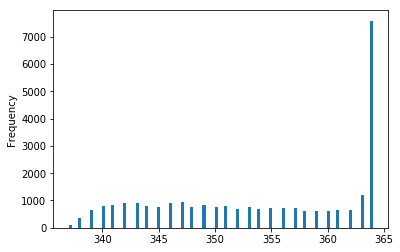

In [33]:
train[train['FILED_3_by_day'] > 10]['FILED_3_by_day'].plot.hist(bins=100)

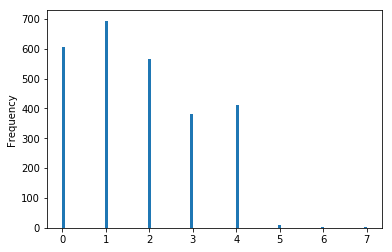

In [34]:
train[train['FILED_3_by_day'] < 10]['FILED_3_by_day'].plot.hist(bins=100)

In [35]:
train['FIELD_11'].plot.hist()


TypeError: Empty 'DataFrame': no numeric data to plot

In [ ]:
train['FIELD_10'].value_counts()

In [ ]:
# dict_count